## Effects of Covid-19 on Housing Prices - Implemented using Dask+Pandas


### We are trying to answer questions related to effect of Covid-19 on housing prices using big data tools like Dask, Pandas. We are using two major datasets of two states Florida and Maryland to answer the questions. Apart from that we are also using rental data, sales housing prices for the whole US data from Zillow API.

#### Florida Dataset: https://bridgedataoutput.com/docs/explorer/public-data#listTransactions
#### Maryland Dataset: https://catalog.data.gov/dataset/maryland-real-property-assessments-hidden-property-owner-names
#### Zillow Dataset for rental, sales housing: https://www.zillow.com/research/data/
#### Median Income: https://www.flhealthcharts.gov/charts/default.aspx, https://hdpulse.nimhd.nih.gov/data-portal/social/table?race=00&race_options=race_7&sex=0&sex_options=sexboth_1&age=001&age_options=ageall_1&statefips_options=area_states&demo=00011&demo_options=income_3&socialtopic=030&socialtopic_options=social_6&statefips=24
#### Shape Files for Heat Map: https://catalog.data.gov/dataset/tiger-line-shapefile-2019-county-florida-municipio-pr-feature-names-county-based-relationship-f

#### importing useful librabries


In [2]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dask_saturn import SaturnCluster    #importing modules
from dask.distributed import Client
import matplotlib.ticker as ticker
import os

In [ ]:
%env SATURN_BASE_URL=https://app.community.saturnenterprise.io
%env SATURN_TOKEN=server-###############

env: SATURN_BASE_URL=https://app.community.saturnenterprise.io
env: SATURN_TOKEN=server-93277a5aa7b5438482722e34b9dd70a9


In [19]:
cluster=SaturnCluster()       # initializing dask cluster
client=Client(cluster)
client

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
/Users/aniket/anaconda3/envs/saturn/lib/python3.9/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.6  | 1.0.5     | 1.0.5   |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
INFO:dask-saturn:Success!


<Client: 'tcp://192.168.53.195:8786' processes=3 threads=6, memory=43.31 GiB>

##### Reading aws credentials

In [2]:
credentials_path='./credentials/aws_credentials.txt'   
os.environ['region_name']='us-east-1'
with open(credentials_path) as aws_credentials:    # accessing the credentials
    for line in aws_credentials:
        if "=" in line:
            key,val=line.split("=",1)
            os.environ[key.strip().upper()]=val.strip()

## Exploring and Cleaning the Florida data

### Reading the data

In [80]:
florida_housing_ddf = dd.read_csv('./dataset/florida_data/*.csv',dtype={'buyerMultiVesting': 'object',
       'effectiveDate': 'object',
       'intraFamilyTransfer': 'object',
       'lenderType': 'object',
       'partialInterestTransfer': 'object',
       'recordingPageNumber': 'object',
       'signatureDate': 'object',
       'recordingBookNumber': 'object',
       'titleCompanyName': 'object'})

In [79]:
## saving the dataset in parquet form and then uploaded the data to S3 bucket
florida_housing_ddf.to_parquet(
    './dataset/florida_dataset',
    engine='pyarrow',  # or 'fastparquet'
    compression='snappy',  # Other options include 'gzip', 'brotli', etc.
    write_index=True
)

##### Reading from S3 bucket

In [3]:
florida_housing_ddf = dd.read_parquet('s3://covidprojectbucket/florida_dataset/*.parquet', engine="pyarrow")

In [81]:
florida_housing_ddf

Dask DataFrame Structure:
               cityTransferTax salesPrice intraFamilyTransfer loanRateTypeCode loanTypeCode transferTaxExempt unpaidBalance partialInterestTransferPercent     id   state countyTransferTax loanTermMonths totalTransferTax delinquentAsOfDate origLoanRecordingDate buyerMultiVesting   fips recordingDate auctionAddress origLoanDocumentDate auctionDate loanDueDate documentTypeCode signatureDate initialInterestRate origLoanAmount totalDelinquentAmount occupancyStatus borrowerVesting titleCompanyName parcels documentDate documentType lenderType installmentAmount sellerName maxLoanAmount loanTermYears loanClosedOrOpenEndedCode recordingPageNumber installmentDueDate trusteeSaleNumber buyerVesting recordingBookNumber recordType origLoanDocumentNumber startingBid partialInterestTransfer buyerName loanAmountDescription loanAmount stateTransferTax lenderName category effectiveDate     url
npartitions=18                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                       float64      int64              object          float64      float64           float64       float64                        float64  int64  object           float64        float64          float64            float64               float64            object  int64        object        float64              float64     float64     float64            int64        object             float64        float64               float64          object         float64           object  object       object       object     object           float64     object       float64       float64                   float64              object            float64           float64      float64              object     object                float64     float64                  object    object               float64    float64          float64    float64   object        object  object
                           ...        ...                 ...              ...          ...               ...           ...                            ...    ...     ...               ...            ...              ...                ...                   ...               ...    ...           ...            ...                  ...         ...         ...              ...           ...                 ...            ...                   ...             ...             ...              ...     ...          ...          ...        ...               ...        ...           ...           ...                       ...                 ...                ...               ...          ...                 ...        ...                    ...         ...                     ...       ...                   ...        ...              ...        ...      ...           ...     ...
...                        ...        ...                 ...              ...          ...               ...           ...                            ...    ...     ...               ...            ...              ...                ...                   ...               ...    ...           ...            ...                  ...         ...         ...              ...           ...                 ...            ... 

In [82]:
total_rows = florida_housing_ddf.shape[0].compute()
print(f"The total number of rows is: {total_rows}")

The total number of rows is: 1799600


#### Analyzing columns in the dataset

In [83]:
florida_housing_ddf.columns

Index(['cityTransferTax', 'salesPrice', 'intraFamilyTransfer',
       'loanRateTypeCode', 'loanTypeCode', 'transferTaxExempt',
       'unpaidBalance', 'partialInterestTransferPercent', 'id', 'state',
       'countyTransferTax', 'loanTermMonths', 'totalTransferTax',
       'delinquentAsOfDate', 'origLoanRecordingDate', 'buyerMultiVesting',
       'fips', 'recordingDate', 'auctionAddress', 'origLoanDocumentDate',
       'auctionDate', 'loanDueDate', 'documentTypeCode', 'signatureDate',
       'initialInterestRate', 'origLoanAmount', 'totalDelinquentAmount',
       'occupancyStatus', 'borrowerVesting', 'titleCompanyName', 'parcels',
       'documentDate', 'documentType', 'lenderType', 'installmentAmount',
       'sellerName', 'maxLoanAmount', 'loanTermYears',
       'loanClosedOrOpenEndedCode', 'recordingPageNumber',
       'installmentDueDate', 'trusteeSaleNumber', 'buyerVesting',
       'recordingBookNumber', 'recordType', 'origLoanDocumentNumber',
       'startingBid', 'partialInterest

#### Parcels has addition fields which needs to be extraced and used as individual columns

In [84]:
print(f'Column count before extracting parcels: {len(florida_housing_ddf.columns)}')

Column count before extracting parcels: 56


In [85]:
florida_housing_ddf['parcels'].head(3)

0    [{'zip': None, 'city': None, 'coordinates': No...
1    [{'zip': '32962', 'city': 'Vero Beach', 'coord...
2    [{'zip': None, 'city': None, 'coordinates': No...
Name: parcels, dtype: object

In [86]:
housing_df = florida_housing_ddf.compute()
df=housing_df
df['parcels'] = housing_df['parcels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_expanded = df['parcels'].apply(lambda x: x[0] if x else None).apply(pd.Series)
df_final = pd.concat([df.drop('parcels', axis=1), df_expanded], axis=1)

In [87]:
df_final

cityTransferTax  salesPrice intraFamilyTransfer  loanRateTypeCode  \
0                  0.0        3600                 NaN               NaN   
1                  0.0       99600                 NaN               NaN   
2                  0.0      250000                 NaN               NaN   
3                  0.0      330000                 NaN               NaN   
4                  0.0     1100000                 NaN               NaN   
...                ...         ...                 ...               ...   
99975              NaN      230000                 NaN               NaN   
99976              0.0      165000                 NaN               NaN   
99977              0.0      270000                 NaN               NaN   
99978              0.0      227000                 NaN               NaN   
99979              0.0      600000                 NaN               NaN   

       loanTypeCode  transferTaxExempt  unpaidBalance  \
0               NaN                NaN            NaN   
1               NaN                NaN            NaN   
2               NaN                NaN            NaN   
3               NaN                NaN            NaN   
4               NaN                NaN            NaN   
...             ...                ...            ...   
99975           NaN                NaN            NaN   
99976           NaN                NaN            NaN   
99977           NaN                NaN            NaN   
99978           NaN                NaN            NaN   
99979           NaN                NaN            NaN   

       partialInterestTransferPercent         id  state  ...    parcelID  \
0                                 NaN  734675939     FL  ...         NaN   
1                                 NaN  731953803     FL  ...  25321232.0   
2                                 NaN  733030074     FL  ...         NaN   
3                                 NaN  730972713     FL  ...  29747337.0   
4                                 NaN  734267327     FL  ...  26923960.0   
...                               ...        ...    ...  ...         ...   
99975                             NaN  730145647     FL  ...  23315632.0   
99976                             0.0  731548911     FL  ...  21884789.0   
99977                             0.0  729494503     FL  ...         NaN   
99978                             0.0  729637201     FL  ...  22056082.0   
99979                             NaN  732077430     FL  ...  23590588.0   

       unitType  unit      street  houseExt streetSuffix  state  \
0          None  None        None      None         None   None   
1          None  None  Pine Arbor      None           Ln     FL   
2          None  None        None      None         None   None   
3          None  None      Meadow      None           Dr     FL   
4           Apt  3408     Collins      None          Ave     FL   
...         ...   ...         ...       ...          ...    ...   
99975      None  None      Bailey      None          Way     FL   
99976      None  None     Hammock      None           Rd     FL   
99977      None  None        None      None         None   None   
99978      Unit   101  Revolution      None           St     FL   
99979      None  None  New Market      None           Rd     FL   

                           apn  streetPost  \
0                         None        None   
1       33401900003031000201.0        None   
2                         None        None   
3      06-29-16-02844-000-0040        None   
4             02-3223-017-3050        None   
...                        ...         ...   
99975   02-05-25-008823-019-05        None   
99976          21-35-05-00-777        None   
99977                     None        None   
99978         27-37-08-77-50-6        None   
99979              63864480007           E   

                                             full  
0                                            None  
1            31 Pine Arbor Ln Vero

In [88]:
df_final.to_csv('./dataset/expanded_parcels.csv', index=False) ##saving the expanded file

In [89]:
florida_housing_ddf=dd.read_csv('./dataset/expanded_parcels.csv',dtype={'buyerMultiVesting': 'object',
       'effectiveDate': 'object',
       'house': 'object',
       'intraFamilyTransfer': 'object',
       'lenderType': 'object',
       'partialInterestTransfer': 'object',
       'signatureDate': 'object',
       'streetPost': 'object',
       'unit': 'object',
       'recordingPageNumber': 'object',
       'recordingBookNumber': 'object',
       'titleCompanyName': 'object'})

In [90]:
florida_housing_ddf.shape[0].compute()

1799600

### Florida data is ready to use

## Answering the questions 

### Q1) Determine the county using the fips code with the maximum mean sales of housing in Florida? Does the median income and mean sales at the county correlated?  

### a) Find the fips code with max mean sales transactions and plot the heat map

In [149]:
mean_sales_ddf = florida_housing_ddf.groupby('fips')['salesPrice'].mean().compute()
mean_sales_df = mean_sales_ddf.to_frame(name='mean_saleprice').reset_index()
max_mean_sale_row = mean_sales_df.loc[mean_sales_df['mean_saleprice'].idxmax()]
fips_with_max_mean_sale = max_mean_sale_row['fips']
max_mean_sale = max_mean_sale_row['mean_saleprice']
print(f'Fip code: {int(fips_with_max_mean_sale)} has the max mean sales transactions of: {max_mean_sale} dollars')

Fip code: 12087 has the max mean sales transactions of: 938060.2169263673 dollars


#### Plotting the heatmap showing the county with max sales

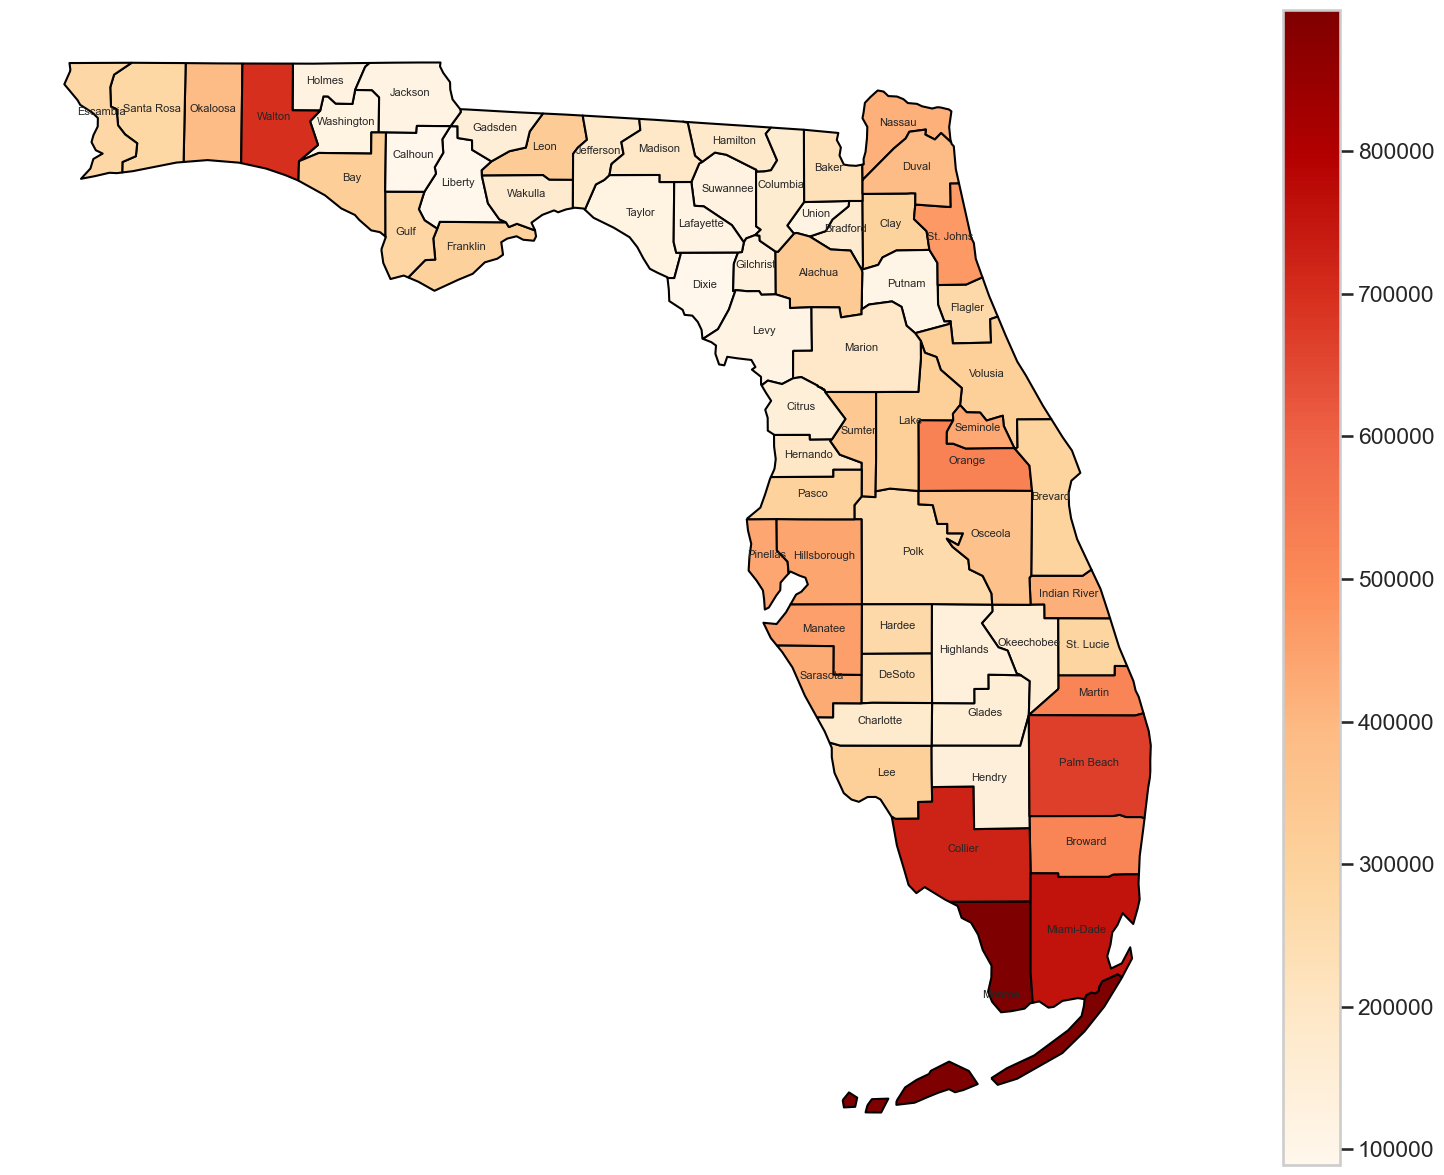

In [112]:
import geopandas as gpd

# Aggregate sales by FIPS code to find the sum of sale price
sum_sales_ddf = florida_housing_ddf.groupby('fips')['salesPrice'].mean().compute()

# Convert the Dask Series to a Pandas DataFrame for geospatial merging
sum_sales_ddf = sum_sales_ddf.to_frame(name='max_saleprice').reset_index()

# Load the Florida counties shapefile with geopandas
florida_counties_gdf = gpd.read_file('dataset/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')

florida_counties_gdf['fips'] = florida_counties_gdf['GEOID'].astype(str)
florida_counties_gdf['NAME'] = florida_counties_gdf['NAME'].astype(str)
sum_sales_ddf['fips']=sum_sales_ddf['fips'].astype(str)
florida_sales_map = florida_counties_gdf.merge(sum_sales_ddf, on='fips')

# Define your scale range here
vmin = (florida_sales_map['max_saleprice'].min())
vmax = (florida_sales_map['max_saleprice'].max())

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
florida_sales_map.plot(column='max_saleprice', ax=ax, legend=True, cmap='OrRd',  edgecolor='black', vmin=vmin, vmax=vmax)

for idx, row in florida_sales_map.iterrows():
    # Get the position for the annotation (county names)
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['NAME'], xy=pos, horizontalalignment='center', fontsize=8)

plt.axis('off')
plt.show()

### b) Find the relation between the median income at a particular fip code and the sales transactions

#### Got this median-income data for florida state of year 2021 from https://www.flhealthcharts.gov/

In [113]:
## Reading the median income dataset of florida state 
median_income=pd.read_excel('./dataset/median-income.xlsx')  

In [114]:
median_income

FIPS                   Name  2014  2015  2016  2017  2018  2019  2020  \
0   12087     Monroe County, FL   4.2   3.5   3.2   3.3   2.6   2.1   8.2   
1   12109  St. Johns County, FL   4.8   4.0   3.8   3.5   3.0   2.7   5.4   
2   12091   Okaloosa County, FL   5.3   4.6   4.1   3.5   3.1   2.8   5.8   
3   12129    Wakulla County, FL   5.3   4.7   4.2   3.7   3.2   3.0   4.7   
4   12089     Nassau County, FL   6.1   5.2   4.5   4.0   3.3   3.0   5.9   
..    ...                   ...   ...   ...   ...   ...   ...   ...   ...   
63  12119     Sumter County, FL   8.6   7.8   7.2   6.2   5.3   4.8   8.3   
64  12017     Citrus County, FL   8.8   7.6   6.8   6.0   5.4   5.0   8.9   
65  12107     Putnam County, FL   9.0   7.7   6.4   5.5   5.0   4.4   8.4   
66  12055  Highlands County, FL   8.7   7.6   6.6   5.7   5.0   4.7   8.1   
67  12051     Hendry County, FL  11.6  10.7   8.6   7.4   6.3   6.1   8.8   

    2021  2022  Median Household Income (2021)  % of State Median HH Income  
0    3.0   1.9                           68975                     1.093904  
1    3.1   2.3                           94662                     1.501285  
2    3.4   2.4                           69053                     1.095141  
3    3.2   2.5                           71962                     1.141276  
4    3.5   2.5                           78069                     1.238129  
..   ...   ...                             ...                          ...  
63   5.4   4.1                           69707                     1.105513  
64   5.8   4.1                           48237                     0.765011  
65   6.0   4.1                           38759                     0.614695  
66   5.9   4.2                           47820                     0.758398  
67   6.4   4.7                           48841                     0.774590  

[68 rows x 13 columns]

In [115]:
median_income=median_income.rename(columns={
    'Median Household Income (2021)':'Median Income',
    'FIPS ':'fips',
    'Name':'County Name'
})

In [116]:
median_income.columns

Index([                       'fips',                 'County Name',
                              '2014',                          2015,
                                2016,                          2017,
                                2018,                          2019,
                                2020,                          2021,
                              '2022',               'Median Income',
       '% of State Median HH Income'],
      dtype='object')

#### Augmenting the housing dataset with the median income dataset 

In [117]:
florida_housing_ddf = florida_housing_ddf.merge(median_income[['fips', 'County Name', 'Median Income']], on='fips', how='left')

In [118]:
florida_housing_ddf[['fips','County Name','Median Income','salesPrice']].head(3)

fips              County Name  Median Income  salesPrice
0  12133    Washington County, FL          47930        3600
1  12061  Indian River County, FL          61351       99600
2  12103      Pinellas County, FL          61851      250000

#### Checking whether median income and max mean sales at a county are correlated

In [121]:
max_fips_median_income=florida_housing_ddf[florida_housing_ddf['fips']==int(fips_with_max_mean_sale)].compute()
max_fips_median_income[['fips','County Name','Median Income']].head(1)

fips        County Name  Median Income
49  12087  Monroe County, FL          68975

In [120]:
max_median_income=florida_housing_ddf['Median Income'].max().compute()
max_median_income=florida_housing_ddf[florida_housing_ddf['Median Income']==max_median_income].compute()
max_median_income[['fips','County Name','Median Income']].head(1)

fips           County Name  Median Income
154  12109  St. Johns County, FL          94662

#### Thus we can see that the median income and max mean sale transactions at a particular county are not related

### c) Is there any relation between the sales prices and Median Income

In [122]:
column1 = florida_housing_ddf['Median Income'].compute()
column2 = florida_housing_ddf['salesPrice'].compute()

correlation = column1.corr(column2)

In [123]:
print(f'Correlation between Median Income and salesPrices is: {correlation}')

Correlation between Median Income and salesPrices is: 0.03711867251876358


##### It's a very weak correlation

#### Plotting heatmap for median income 

/var/folders/s4/pc8pbq8935s2p_shty3w1p3m0000gn/T/ipykernel_900/3235532768.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  median_income_df['fips']=median_income_df['fips'].astype(str)


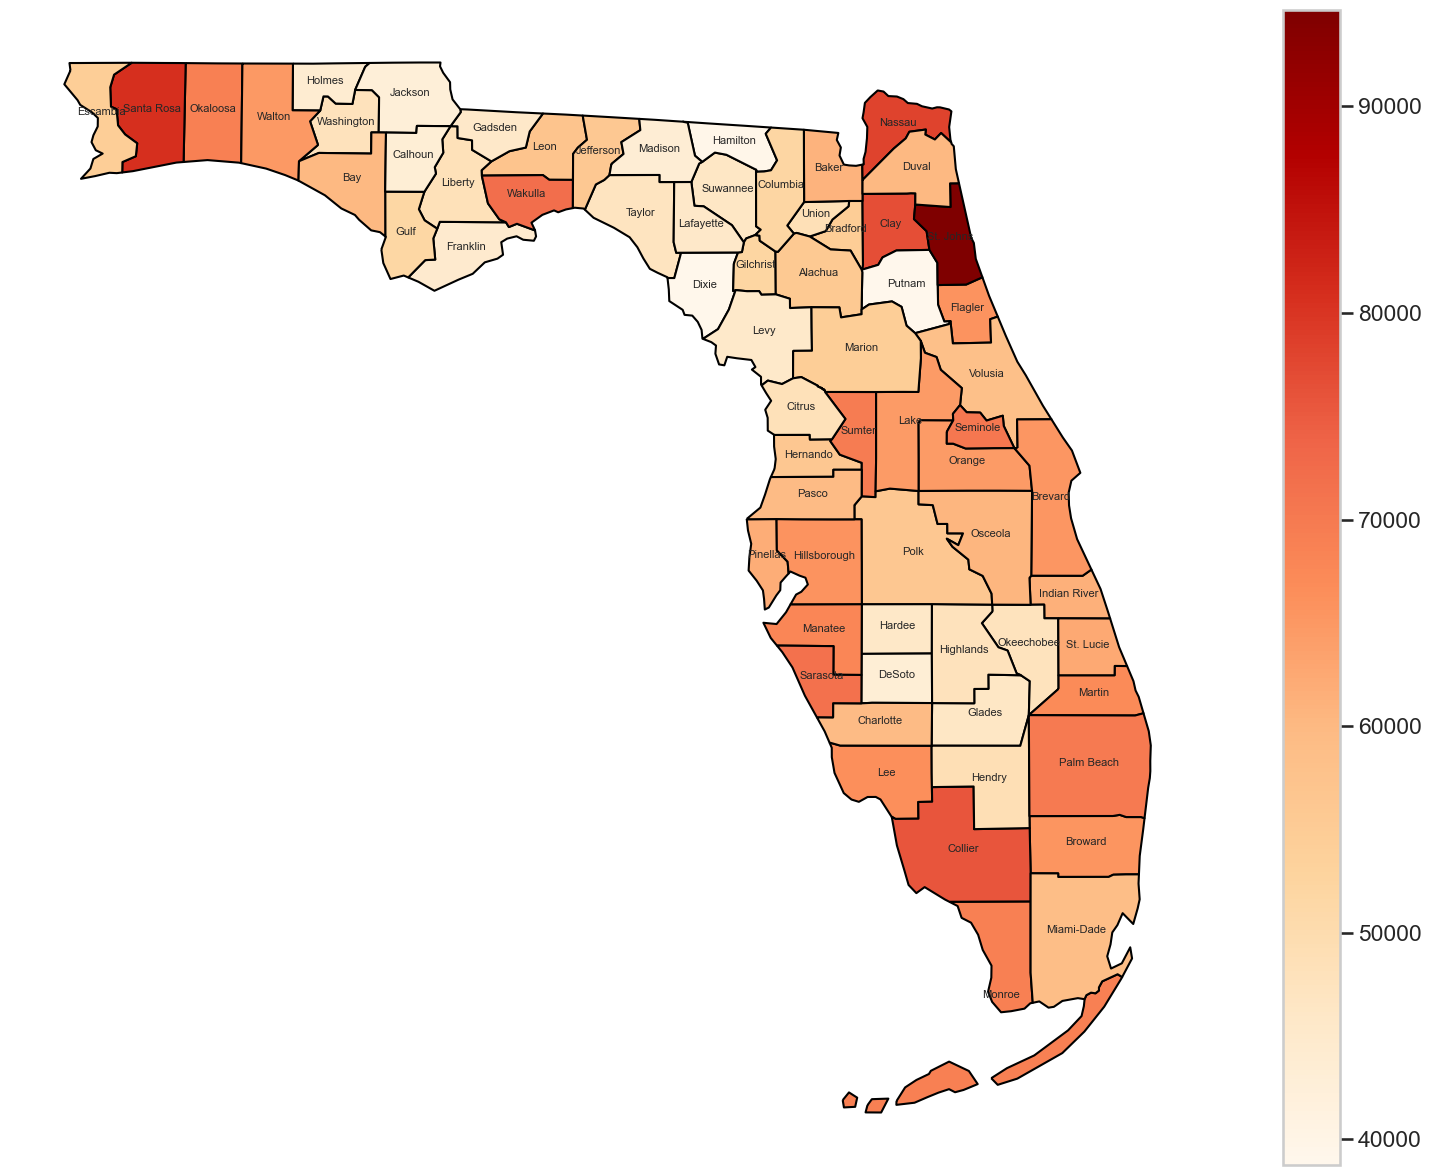

In [126]:
import geopandas as gpd

# Aggregate sales by FIPS code to find the sum of sale price
median_income_df = median_income[['fips','Median Income']]

# Load the Florida counties shapefile with geopandas
florida_counties_gdf = gpd.read_file('dataset/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')


florida_counties_gdf['fips'] = florida_counties_gdf['GEOID'].astype(str)
# max_sales_df['fips'] = max_sales_df['fips'].astype(str)
florida_counties_gdf['NAME'] = florida_counties_gdf['NAME'].astype(str)
median_income_df['fips']=median_income_df['fips'].astype(str)
florida_sales_map = florida_counties_gdf.merge(median_income_df, on='fips')
vmin = (florida_sales_map['Median Income'].min())
vmax = (florida_sales_map['Median Income'].max())

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
florida_sales_map.plot(column='Median Income', ax=ax, legend=True, cmap='OrRd', edgecolor='black',vmin=vmin,vmax=vmax)

for idx, row in florida_sales_map.iterrows():
    # Get the position for the annotation (county names)
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['NAME'], xy=pos, horizontalalignment='center', fontsize=8)

plt.axis('off')
plt.show()

#### Plot the barplot to show the top 10 sales based on fips code

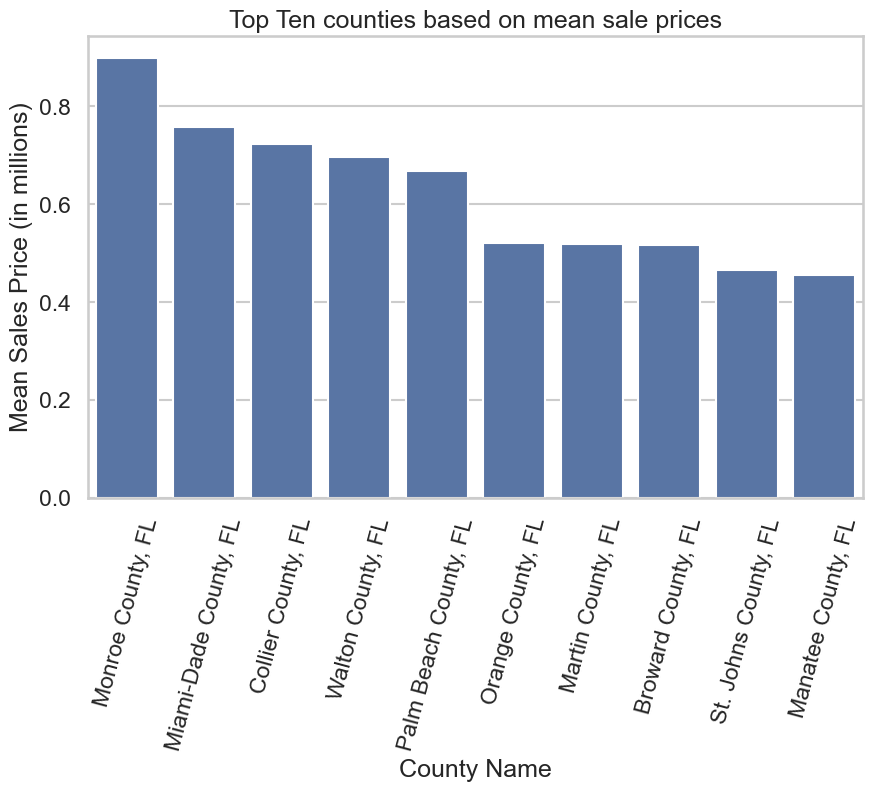

In [141]:
sum_sales_ddf = florida_housing_ddf.groupby('County Name')['salesPrice'].mean().compute()
top_ten_fips = sum_sales_ddf.nlargest(10)
max_sales_df = top_ten_fips.to_frame(name='max_saleprice').reset_index()
max_sales_df['max_mean_saleprice_in_millions'] = max_sales_df['max_saleprice'] / 1e6
plt.figure(figsize=(10, 6))
sns.barplot(x='County Name', y='max_mean_saleprice_in_millions', data=max_sales_df)
plt.xlabel('County Name')
plt.ylabel('Mean Sales Price (in millions)')
plt.title('Top Ten counties based on mean sale prices')
plt.xticks(rotation=75)
plt.show()

## Q2) What is the trend on the house prices due to Covid 19?

#### Plot the trend

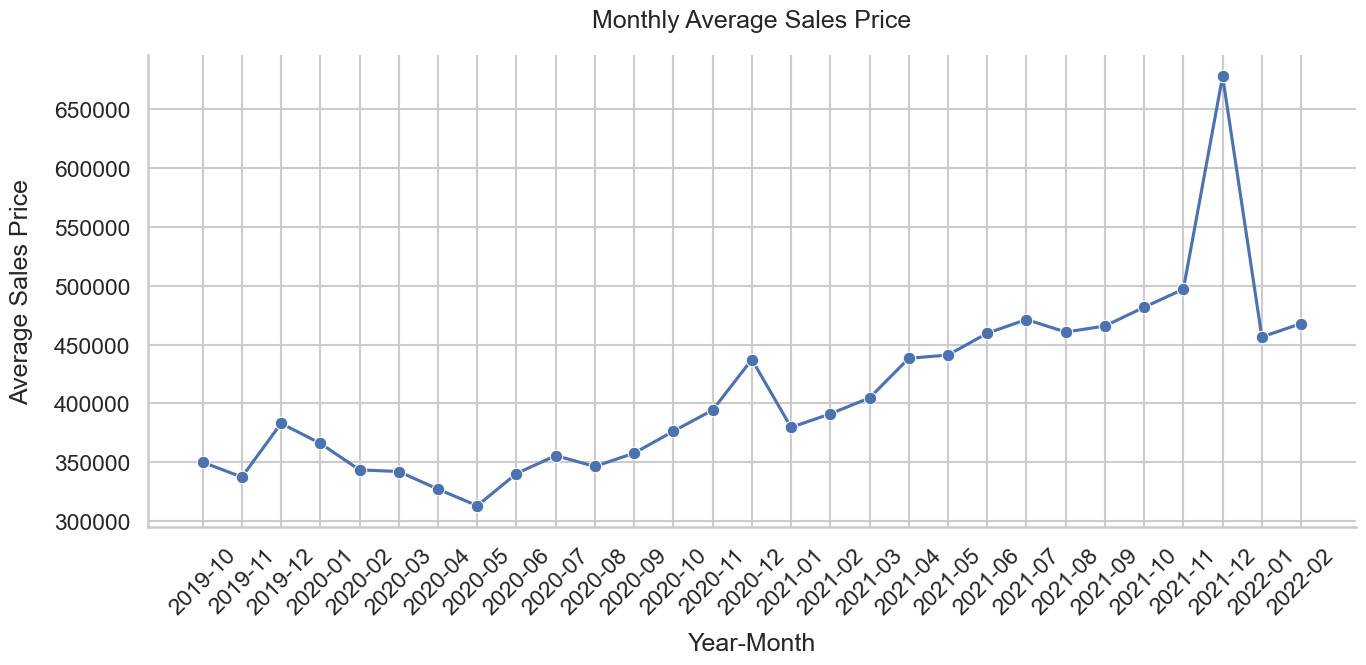

In [138]:
# Convert 'documentDate' to datetime 
florida_housing_ddf['documentDate'] = dd.to_datetime(florida_housing_ddf['documentDate'])
florida_housing_ddf['YearMonth'] = florida_housing_ddf['documentDate'].dt.strftime('%Y-%m')
monthly_avg_sales_price = florida_housing_ddf.groupby('YearMonth')['salesPrice'].mean().compute()
monthly_avg_sales_price = monthly_avg_sales_price.to_frame(name='mean_sales').reset_index()
monthly_avg_sales_price=monthly_avg_sales_price.sort_values(by='YearMonth')
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=monthly_avg_sales_price, x='YearMonth', y='mean_sales', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Average Sales Price', pad=20)
plt.xlabel('Year-Month', labelpad=10)
plt.ylabel('Average Sales Price', labelpad=15)
sns.despine()
plt.tight_layout()
plt.show()

### Q3) Is there any increase in state tax on housing due to Covid 19

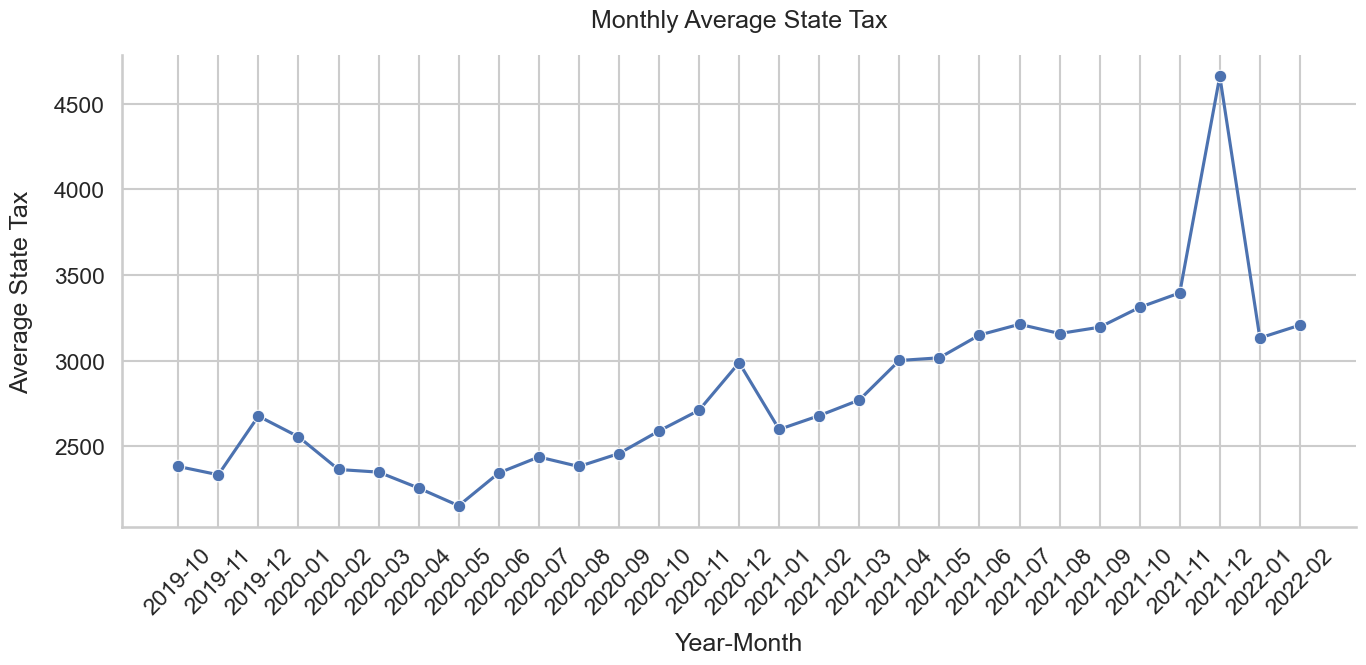

In [139]:
florida_housing_ddf['documentDate'] = dd.to_datetime(florida_housing_ddf['documentDate'])
florida_housing_ddf['YearMonth'] = florida_housing_ddf['documentDate'].dt.strftime('%Y-%m')
monthly_avg_state_tax = florida_housing_ddf.groupby('YearMonth')['stateTransferTax'].mean().compute()
monthly_avg_state_tax = monthly_avg_state_tax.to_frame(name='mean_sales').reset_index()
monthly_avg_state_tax=monthly_avg_state_tax.sort_values(by='YearMonth')
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=monthly_avg_state_tax, x='YearMonth', y='mean_sales', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Average State Tax', pad=20)
plt.xlabel('Year-Month', labelpad=10)
plt.ylabel('Average State Tax', labelpad=15)
sns.despine()
plt.tight_layout()
plt.show()

### Q4)  Were there changes in investment strategies, as evidenced by the types of properties bought or sold due to pandemic?

In [142]:
florida_housing_ddf.unitType.value_counts().compute()

unitType
Apt           150822
#              70259
Unit           38736
Suite           3275
Penthouse       1492
Lot             1381
Building         724
Floor            152
Bldg              56
Ph                15
Office            11
Ste                3
Condo              3
Trailer            2
Space              2
Side               2
Units              2
O-unit             1
20-unit            1
House              1
G-unit             1
Front              1
Dept               1
Box                1
A-building         1
T-unit             1
Townhouse          1
815-unit           1
201-unit           1
Lobby              1
Name: count, dtype: int64

#### remove '#' unit which is a wrong unitType

In [143]:
florida_housing_ddf=florida_housing_ddf[florida_housing_ddf['unitType']!='#']

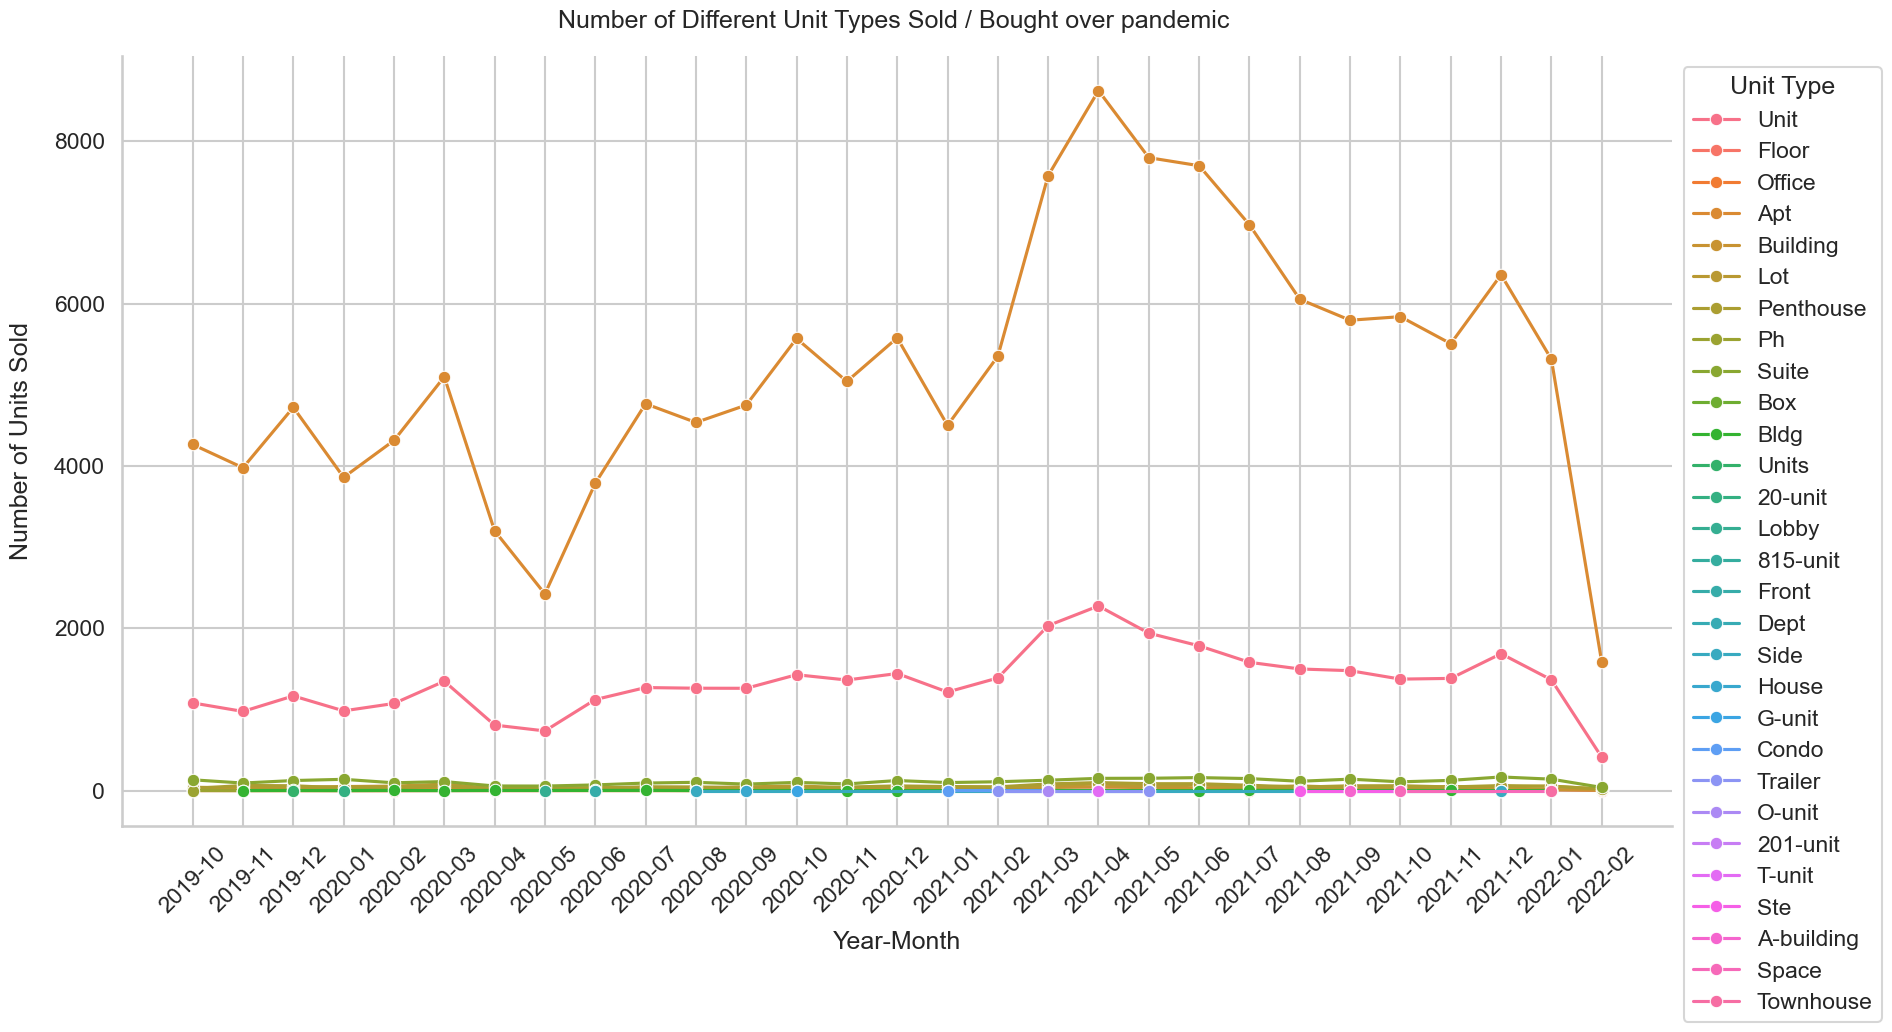

In [148]:
florida_housing_ddf['documentDate'] = dd.to_datetime(florida_housing_ddf['documentDate'])
florida_housing_ddf['YearMonth'] = florida_housing_ddf['documentDate'].dt.strftime('%Y-%m')
unit_sales_counts = florida_housing_ddf.groupby(['YearMonth', 'unitType']).size().compute()
unit_sales_counts_df = unit_sales_counts.to_frame('count').reset_index()
unit_sales_counts_df=unit_sales_counts_df.sort_values(by='YearMonth')
plt.figure(figsize=(20, 10))
sns.lineplot(data=unit_sales_counts_df, x='YearMonth', y='count', hue='unitType', marker='o')
plt.xticks(rotation=45)
plt.title('Number of Different Unit Types Sold / Bought over pandemic ', pad=20)
plt.xlabel('Year-Month', labelpad=10)
plt.ylabel('Number of Units Sold', labelpad=15)
plt.legend(title='Unit Type',loc='upper left', bbox_to_anchor=(1,1)) 
sns.despine()
plt.show()

## Reading and cleaning Maryland data

In [45]:
import dask.dataframe as dd
import numpy as np

# Read your Dask DataFrame (replace with your actual data source)
maryland_ddf = dd.read_csv('./Real-Estate-Dataset/Maryland_Real_Property_Assessments__Hidden_Property_Owner_Names.csv',dtype={
                    'ASSESSMENT CREDIT PROGRAM': 'object',
                    'Current State Assmt Cr (SDAT Field #197)': 'object',
                    'SALES SEGMENT 2: Mkt Land Value (SDAT Field #115)': 'object',
                    'Record Creation Date (YYYY.MM.DD) (SDAT Field #397)' : 'object',
                    'County Name (MDP Field: CNTYNAME)':'object',
                    'Account ID (MDP Field: ACCTID)': 'object',
                    'ADDITIONAL C.A.M.A. Data: Building Style Code and Description (MDP Field: STRUSTYL/DESCSTYL. SDAT Field #264)':'object',
                    'TAX ROLL VALUES: State Assessment (SDAT Field #248)':'object'
})

In [46]:
maryland_ddf.columns

Index(['Jurisdiction Code (MDP Field: JURSCODE)',
       'County Name (MDP Field: CNTYNAME)', 'Account ID (MDP Field: ACCTID)',
       'Real Property Search Link', 'FINDER Online Link',
       'Search Google Maps for this Location',
       'MDP Longitude (MDP Field: DIGXCORD converted to WGS84)',
       'MDP Latitude (MDP Field: DIGYCORD converted to WGS84)',
       'Mappable Latitude and Longitude',
       'RECORD KEY: County Code (SDAT Field #1)',
       ...
       'Plat Reference Liber (MDP Field: PLTLIBER. SDAT Field #267)',
       'Plat Reference Folio (MDP Field: PLTFOLIO. SDAT Field #268)',
       'PARENT ACCOUNT NUMBER: District/Ward (SDAT Field #387)',
       'PARENT ACCOUNT NUMBER: Account Number (SDAT Field #388)',
       'Last Activity Date (YYYY.MM.DD) (SDAT Field #392)',
       'Record Creation Date (YYYY.MM.DD) (SDAT Field #397)',
       'Record Deletion Date (YYYY.MM.DD) (SDAT Field #398)',
       'Assessment Cycle Year (SDAT Field #399)',
       'File Record Type (SDAT

#### selecting just the required columns and renaming the columns

In [47]:
selected_columns = [
'SALES SEGMENT 2: Mkt Land Value (SDAT Field #115)',
'Record Creation Date (YYYY.MM.DD) (SDAT Field #397)',
'County Name (MDP Field: CNTYNAME)','Account ID (MDP Field: ACCTID)',
'ADDITIONAL C.A.M.A. Data: Building Style Code and Description (MDP Field: STRUSTYL/DESCSTYL. SDAT Field #264)',
'TAX ROLL VALUES: State Assessment (SDAT Field #248)']

In [48]:
maryland_ddf=maryland_ddf[selected_columns]
rename_dict = {
    'Record Creation Date (YYYY.MM.DD) (SDAT Field #397)': 'Creation_date',
    'SALES SEGMENT 2: Mkt Land Value (SDAT Field #115)':'Property Value',
    'County Name (MDP Field: CNTYNAME)':'County Name',
    'Account ID (MDP Field: ACCTID)':'Account ID',
    'ADDITIONAL C.A.M.A. Data: Building Style Code and Description (MDP Field: STRUSTYL/DESCSTYL. SDAT Field #264)':'Building Style Code and Description',
    'TAX ROLL VALUES: State Assessment (SDAT Field #248)':'tax-state'
    # Add more columns as necessary
}
maryland_ddf = maryland_ddf.rename(columns=rename_dict)

In [49]:
maryland_ddf

Dask DataFrame Structure:
               Property Value Creation_date County Name Account ID Building Style Code and Description tax-state
npartitions=71                                                                                                  
                       object        object      object     object                              object    object
                          ...           ...         ...        ...                                 ...       ...
...                       ...           ...         ...        ...                                 ...       ...
                          ...           ...         ...        ...                                 ...       ...
                          ...           ...         ...        ...                                 ...       ...
Dask Name: rename, 3 graph layers

In [50]:
maryland_ddf.head(5)

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,22,24,31,36,38,43,63,65,66,165,166,171,172,205,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Property Value Creation_date     County Name  Account ID  \
0      332000.00    0000.00.00  Calvert County  0501000047   
1      217800.00    0000.00.00  Calvert County  0501000055   
2      148700.00    0000.00.00  Calvert County  0501000071   
3           0.00    0000.00.00  Calvert County  0501000098   
4      167720.00    0000.00.00  Calvert County  0501000101   

   Building Style Code and Description tax-state  
0                    RESTAURANT (C166)      0.00  
1      STRY 2 Story No Basement (0005)      0.00  
2      STRY 1 Story No Basement (0001)      0.00  
3    STRY 2 Story With Basement (0006)      0.00  
4  STRY 1 1/2 Story No Basement (0003)      0.00

In [51]:
maryland_ddf=maryland_ddf[maryland_ddf["Creation_date"]!='0000.00.00']  ## removing wrong dates 

In [53]:
maryland_ddf['Property Value']=maryland_ddf['Property Value'].astype(float)
maryland_ddf['tax-state']=maryland_ddf['tax-state'].astype(float)

In [54]:
maryland_ddf.dtypes

Property Value                         float64
Creation_date                           object
County Name                             object
Account ID                              object
Building Style Code and Description     object
tax-state                              float64
dtype: object

In [55]:
maryland_ddf=maryland_ddf[maryland_ddf['Property Value']!=0]  ## removing properties with value 0

In [56]:
## cleaning the data
def clean_date(date_str):
    return date_str.replace(".00.00", ".01.01")

# Assuming 'df' is your Dask dataframe and 'date' is the column with date strings
maryland_ddf['Creation_date'] = maryland_ddf['Creation_date'].map(clean_date,meta=('Creation_date',object))

In [58]:
maryland_ddf['Creation_date'] = dd.to_datetime(maryland_ddf['Creation_date'], format='%Y.%m.%d', errors='coerce')

In [59]:
maryland_ddf.count().compute()

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,29,31,32,36,42,43,48,50,53,63,64,67,91,166,172,205,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (29,30,31,32,36,42,43,48,63,64,65,66,67,78,89,166,171,172,205,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (24,29,31,32,38,41,43,48,50,63,64,65,66,69,80,91,166,171,172,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (24,25,31,36,38,42,43,48,49,63,64,65,66,128,166,172,205,211,212) h

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (32,36,42,43,50,63,64,65,66,69,80,91,128,166,172,211) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,31,32,36,63,64,65,66,69,80,91,128,166,172,175,211,212,214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (31,32,36,42,48,50,63,64,65,66,69,80,89,91,119,120,128,129,166,172,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,22,24,31,32,36,41,43,48,50,53,63,64,65,66,67,69,80,89,91,128,129,165,166,1

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (25,36,37,38,42,43,48,63,78,166,172,205,211) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,24,25,29,31,32,38,43,48,50,56,63,64,65,66,69,78,80,91,166,211,214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,25,30,32,38,42,43,48,50,53,56,63,69,80,91,166,172,205,211,212,214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (22,24,36,38,48,56,63,64,65,66,67,78,166,172,175,211,212,214) have mixed types. Spec

Property Value                         633501
Creation_date                          633488
County Name                            633505
Account ID                             633505
Building Style Code and Description    633505
tax-state                              633490
dtype: int64

In [60]:
maryland_ddf.dtypes

Property Value                                float64
Creation_date                          datetime64[ns]
County Name                                    object
Account ID                                     object
Building Style Code and Description            object
tax-state                                     float64
dtype: object

In [61]:
maryland_ddf.to_parquet(
    './dataset/cleaned_maryland_dataset',
    engine='pyarrow',  # or 'fastparquet'
    compression='snappy',  # Other options include 'gzip', 'brotli', etc.
    write_index=True
)

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (29,30,31,32,36,42,43,48,63,64,65,66,67,78,89,166,171,172,205,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (24,25,31,36,38,42,43,48,49,63,64,65,66,128,166,172,205,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (24,29,31,32,38,41,43,48,50,63,64,65,66,69,80,91,166,171,172,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,24,31,32,36,38,50,53,63,64,65,66,67,69,80,91,166,172,175,211)

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (32,36,42,43,50,63,64,65,66,69,80,91,128,166,172,211) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (31,32,36,42,48,50,63,64,65,66,69,80,89,91,119,120,128,129,166,172,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,31,32,36,63,64,65,66,69,80,91,128,166,172,175,211,212,214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,24,29,38,41,43,48,50,53,63,64,65,66,67,69,80,91,128,129,166,172,175,212) h

/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (24,38,48,50,56,63,64,65,66,67,128,129,166,172,211,214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (25,36,37,38,42,43,48,63,78,166,172,205,211) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (11,24,25,29,31,32,38,43,48,50,56,63,64,65,66,69,78,80,91,166,211,214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/aniket/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (22,24,36,38,48,56,63,64,65,66,67,78,166,172,175,211,212,214) have mixed types. Specify dtype optio

### Q1) Determine the county using the fips code with the maximum mean sales of housing in Maryland? Does the median income and mean sales at the county correlated?  

In [270]:
maryland_ddf = dd.read_parquet('./dataset/cleaned_maryland_dataset/part.*.parquet',assume_missing=True)

In [256]:
maryland_ddf.shape[0].compute()

633505

In [272]:
start_date = pd.Timestamp('2019-10-01')
end_date = pd.Timestamp('2023-10-01')

# Filter rows between start date and end date
maryland_ddf = maryland_ddf[(maryland_ddf['Creation_date'] >= start_date) & (maryland_ddf['Creation_date'] <= end_date)]

### a) Find the county with max mean sales transactions and plot the heat map

In [258]:
mean_sales_ddf = maryland_ddf.groupby('County Name')['Property Value'].mean().compute()
mean_sales_df = mean_sales_ddf.to_frame(name='mean_saleprice').reset_index()
max_mean_sale_row = mean_sales_df.loc[mean_sales_df['mean_saleprice'].idxmax()]
fips_with_max_mean_sale = max_mean_sale_row['County Name']
max_mean_sale = max_mean_sale_row['mean_saleprice']
print(f'Fip code: {fips_with_max_mean_sale} has the max mean sales transactions of: {max_mean_sale} dollars')

Fip code: Kent County has the max mean sales transactions of: 242700.0 dollars


#### Plotting the heatmap showing the county with max mean sales for Maryland

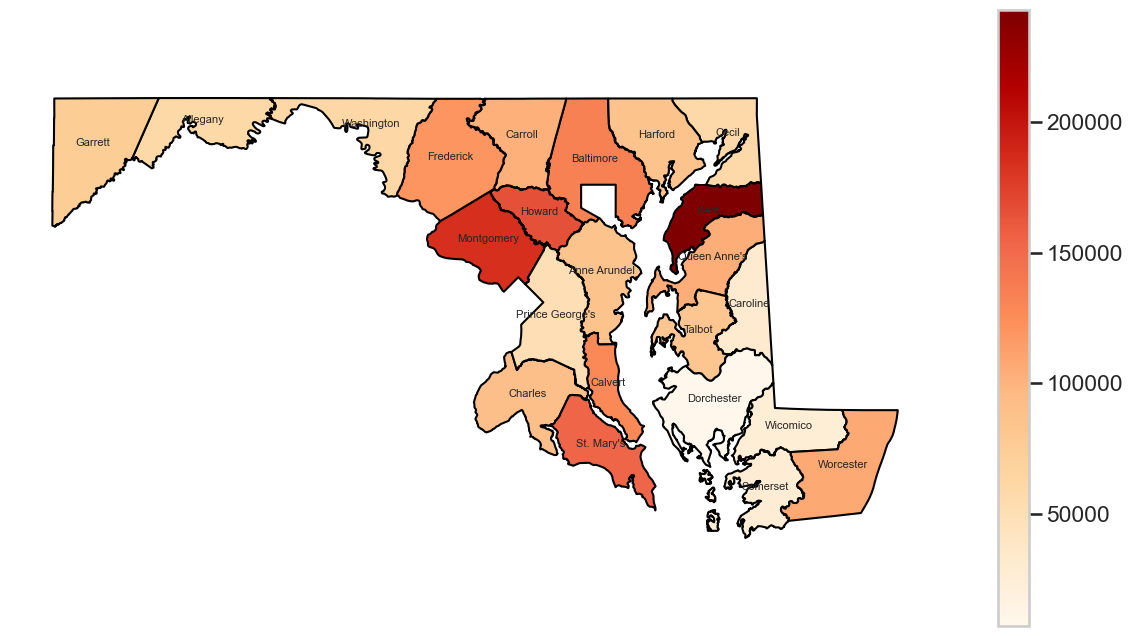

In [259]:
import geopandas as gpd

# Aggregate sales by FIPS code to find the sum of sale price
sum_sales_ddf = maryland_ddf.groupby('County Name')['Property Value'].mean().compute()

# Convert the Dask Series to a Pandas DataFrame for geospatial merging
sum_sales_ddf = sum_sales_ddf.to_frame(name='max_saleprice').reset_index()
sum_sales_ddf['County Name'] = sum_sales_ddf['County Name'].str.replace(' County', '')
sum_sales_ddf = sum_sales_ddf.rename(columns={'County Name': 'Name'})

# # # Load the Florida counties shapefile with geopandas
maryland_counties_gdf = gpd.read_file('dataset/Maryland_Physical_Boundaries_-_County_Boundaries_(Generalized)/Maryland_Physical_Boundaries_-_County_Boundaries_(Generalized).shp')
sum_sales_ddf
maryland_counties_gdf['Name'] = maryland_counties_gdf['county'].astype(str)
sum_sales_ddf['Name']=sum_sales_ddf['Name'].astype(str)

maryland_sales_map = maryland_counties_gdf.merge(sum_sales_ddf, on='Name')
vmin = (maryland_sales_map['max_saleprice'].min())
vmax = (maryland_sales_map['max_saleprice'].max())
# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
maryland_sales_map.plot(column='max_saleprice', ax=ax, legend=True, cmap='OrRd', edgecolor='black', vmin=vmin,vmax=vmax)

for idx, row in maryland_sales_map.iterrows():
    # Get the position for the annotation (county names)
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Name'], xy=pos, horizontalalignment='center', fontsize=8)

plt.axis('off')
plt.show()

#### Plot the barplot to show the top 10 sales based on fips code

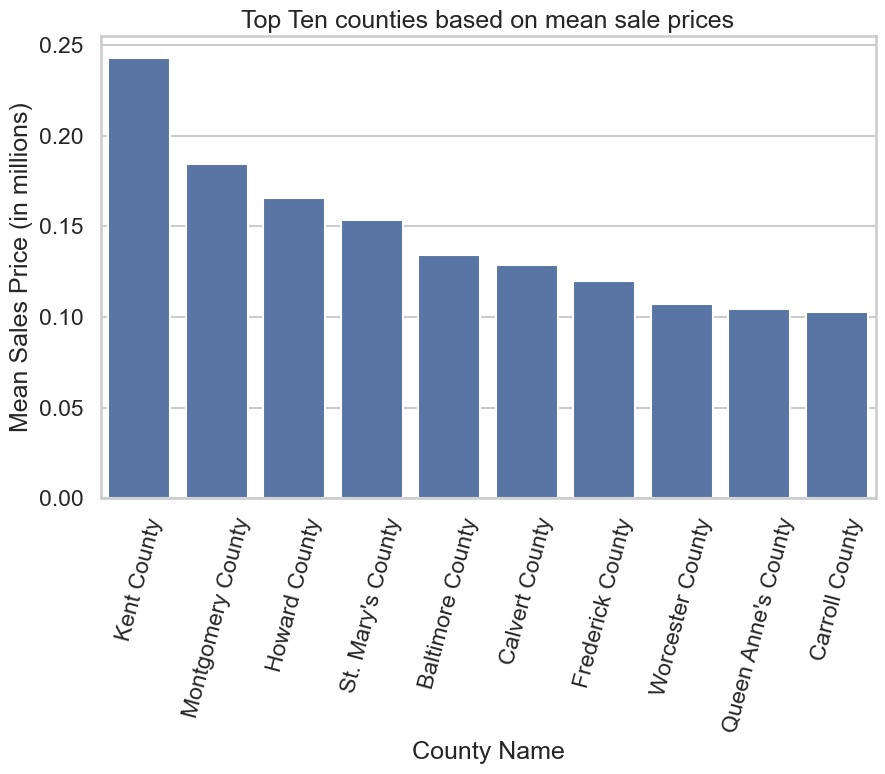

In [260]:
sum_sales_ddf = maryland_ddf.groupby('County Name')['Property Value'].mean().compute()
top_ten_fips = sum_sales_ddf.nlargest(10)
max_sales_df = top_ten_fips.to_frame(name='max_saleprice').reset_index()
max_sales_df['max_mean_saleprice_in_millions'] = max_sales_df['max_saleprice'] / 1e6
plt.figure(figsize=(10, 6))
sns.barplot(x='County Name', y='max_mean_saleprice_in_millions', data=max_sales_df)
plt.xlabel('County Name')
plt.ylabel('Mean Sales Price (in millions)')
plt.title('Top Ten counties based on mean sale prices')
plt.xticks(rotation=75)
plt.show()

### b) Find the relation between the median income at a particular fip code and the sales transactions`

In [261]:
maryland_income_ddf = dd.read_csv('./dataset/median_income_maryland.csv',dtype={'Rank within US (of 3141 counties)': 'float64'}) ## maryland income

In [262]:
maryland_income_ddf.columns

Index(['County', ' FIPS', 'Value (Dollars)',
       'Rank within US (of 3141 counties)'],
      dtype='object')

In [263]:
maryland_income_ddf=maryland_income_ddf.rename(columns={
    'Value (Dollars)':'Median Income',
    ' FIPS':'fips',
    'County':'County Name'
})

In [264]:
maryland_ddf = maryland_ddf.merge(maryland_income_ddf[['fips', 'County Name', 'Median Income']], on='County Name', how='left')


#### Checking whether median income and max mean sales at a county are correlated

In [265]:
max_fips_median_income=maryland_ddf[maryland_ddf['County Name']==fips_with_max_mean_sale].compute()
max_fips_median_income[['fips','County Name','Median Income']].head(1)

fips  County Name  Median Income
0  24029  Kent County          64451

In [266]:
max_median_income=maryland_ddf['Median Income'].max().compute()
max_median_income=maryland_ddf[maryland_ddf['Median Income']==max_median_income].compute()
max_median_income[['fips','County Name','Median Income']].head(1)

fips    County Name  Median Income
0  24027.0  Howard County       129549.0

#### Thus we can see that the median income and max mean sale transactions at a particular county are not related

### c) Is there any relation between the sales prices and Median Income

In [267]:
column1 = maryland_ddf['Median Income'].compute()
column2 = maryland_ddf['Property Value'].compute()

correlation = column1.corr(column2)

In [268]:
print(f'Correlation between Median Income and salesPrices is: {correlation}')

Correlation between Median Income and salesPrices is: 0.09950943924144236


##### There is a very weak relation between median income and salesprices / property values

### plotting median income heatmap 

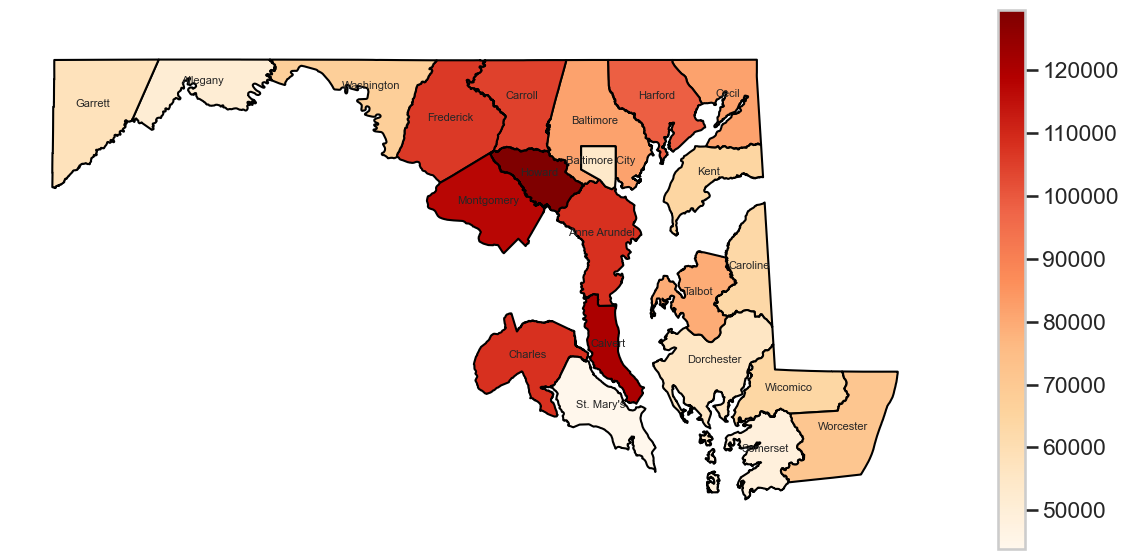

In [232]:
import geopandas as gpd

# Aggregate sales by FIPS code to find the sum of sale price
sum_sales_ddf = maryland_income_ddf[['Median Income','County Name']].compute()
sum_sales_ddf['County Name'] = sum_sales_ddf['County Name'].str.replace(' County', '')
sum_sales_ddf = sum_sales_ddf.rename(columns={'County Name': 'Name'})
sum_sales_ddf

# # Load the Florida counties shapefile with geopandas
maryland_counties_gdf = gpd.read_file('dataset/Maryland_Physical_Boundaries_-_County_Boundaries_(Generalized)/Maryland_Physical_Boundaries_-_County_Boundaries_(Generalized).shp')
maryland_counties_gdf['Name'] = maryland_counties_gdf['county'].astype(str)
sum_sales_ddf['Name']=sum_sales_ddf['Name'].astype(str)

maryland_sales_map = maryland_counties_gdf.merge(sum_sales_ddf, on='Name')

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
maryland_sales_map.plot(column='Median Income', ax=ax, legend=True, cmap='OrRd', edgecolor='black')

for idx, row in maryland_sales_map.iterrows():
    # Get the position for the annotation (county names)
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Name'], xy=pos, horizontalalignment='center', fontsize=8)

plt.axis('off')
plt.show()

## Q2) What is the trend on the prices due to Covid 19?

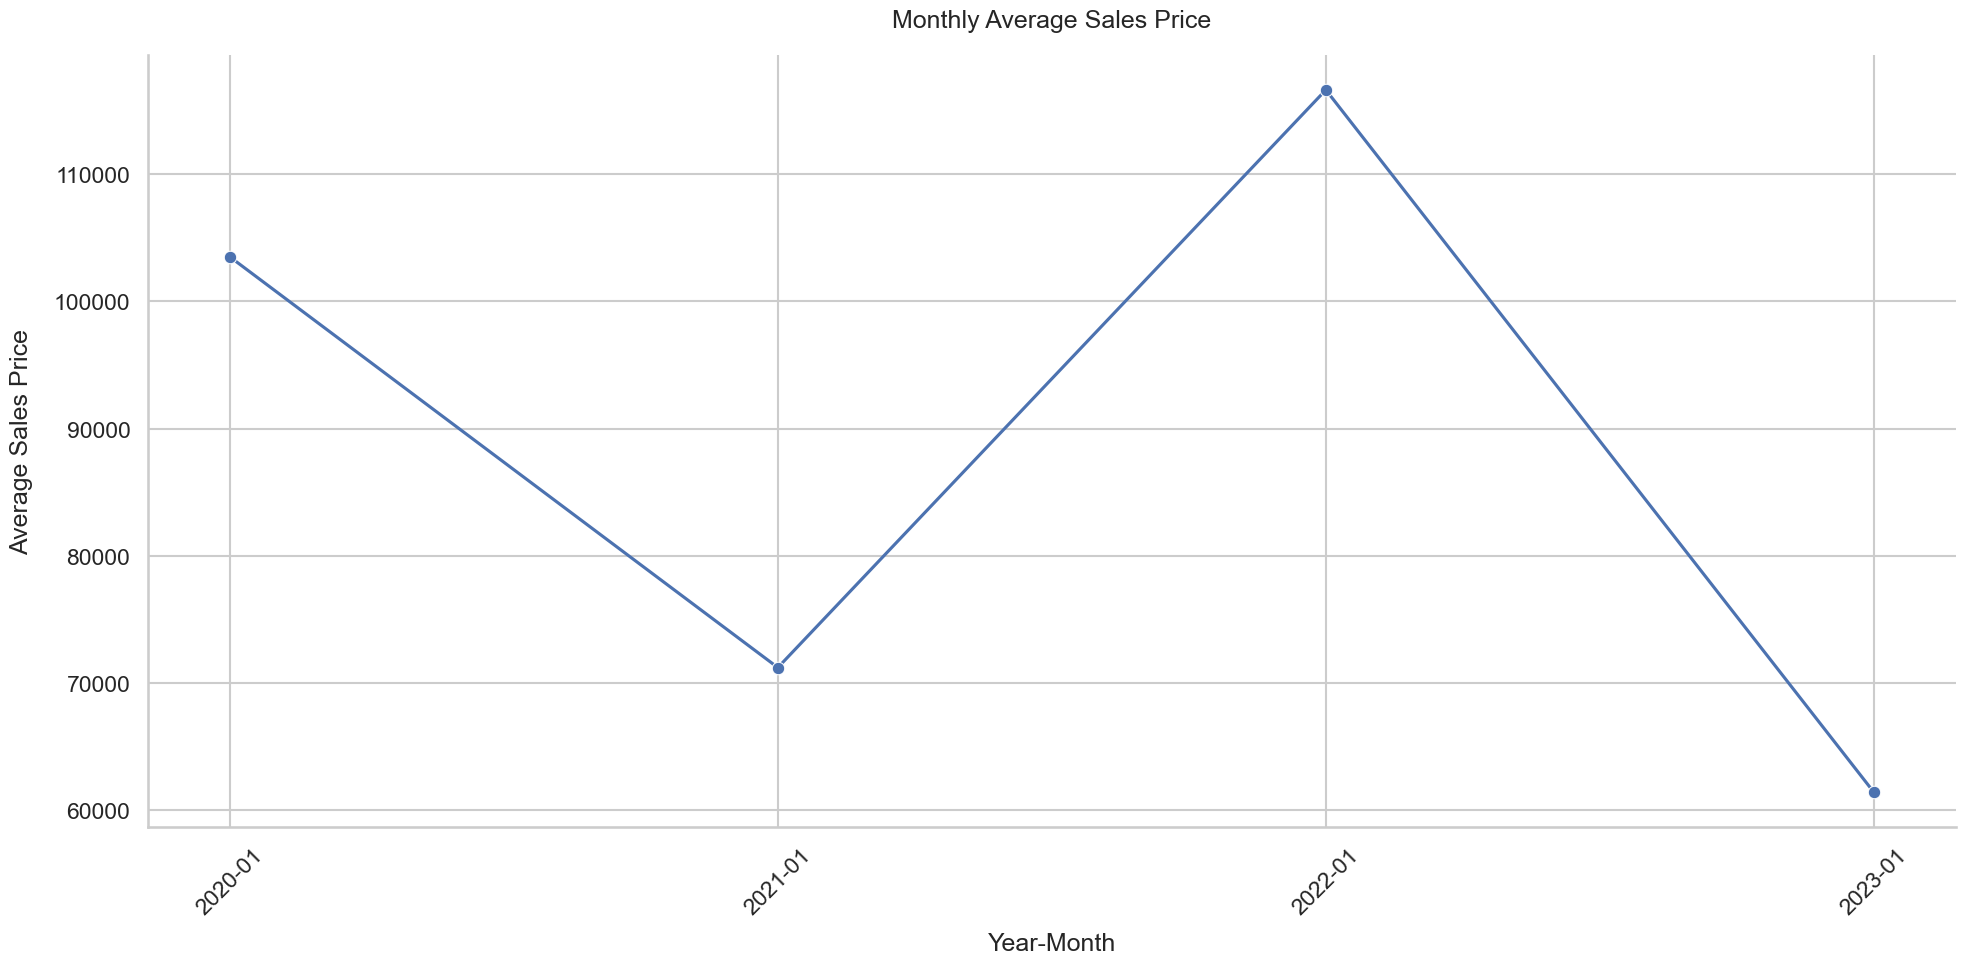

In [273]:
# Convert 'documentDate' to datetime 
maryland_ddf['Creation_date'] = dd.to_datetime(maryland_ddf['Creation_date'])
maryland_ddf['YearMonth'] = maryland_ddf['Creation_date'].dt.strftime('%Y-%m')
monthly_avg_sales_price = maryland_ddf.groupby('YearMonth')['Property Value'].mean().compute()
monthly_avg_sales_price = monthly_avg_sales_price.to_frame(name='mean_sales').reset_index()
monthly_avg_sales_price=monthly_avg_sales_price.sort_values(by='YearMonth')
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=monthly_avg_sales_price, x='YearMonth', y='mean_sales', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Average Sales Price', pad=20)
plt.xlabel('Year-Month', labelpad=10)
plt.ylabel('Average Sales Price', labelpad=15)
sns.despine()
plt.tight_layout()
plt.show()

## Examine Rental Properties Florida + Maryland 

## Q5) What is the trend on the rental prices due to Covid 19?

In [274]:
rental_df=pd.read_csv('./dataset/rental-allhomes.csv')

In [275]:
rental_df

RegionID  SizeRank       RegionName RegionType StateName   2015-01-31  \
0      102001         0    United States    country       NaN  1258.829246   
1      394913         1     New York, NY        msa        NY  2369.677360   
2      753899         2  Los Angeles, CA        msa        CA  1874.902698   
3      394463         3      Chicago, IL        msa        IL  1399.490422   
4      394514         4       Dallas, TX        msa        TX  1125.269027   
..        ...       ...              ...        ...       ...          ...   
595    394687       875   Hood River, OR        msa        OR          NaN   
596    394868       878     Mitchell, SD        msa        SD          NaN   
597    395198       882     Wahpeton, ND        msa        ND          NaN   
598    394718       892    Jamestown, ND        msa        ND          NaN   
599    394996       915     Portales, NM        msa        NM          NaN   

      2015-02-28   2015-03-31   2015-04-30   2015-05-31  ...   2023-01-31  \
0    1265.589842  1274.604961  1284.582431  1294.436165  ...  1944.174094   
1    2385.556272  2403.633122  2426.024982  2442.095992  ...  3113.490723   
2    1886.461962  1901.646902  1915.772142  1930.820309  ...  2884.393939   
3    1406.984261  1417.888874  1427.527483  1438.368768  ...  1843.681256   
4    1130.741988  1138.718751  1149.772703  1160.036742  ...  1773.147521   
..           ...          ...          ...          ...  ...          ...   
595          NaN          NaN          NaN          NaN  ...          NaN   
596          NaN          NaN          NaN          NaN  ...          NaN   
597          NaN          NaN          NaN          NaN  ...          NaN   
598          NaN          NaN          NaN          NaN  ...   806.690475   
599          NaN          NaN          NaN          NaN  ...          NaN   

      2023-02-28   2023-03-31   2023-04-30   2023-05-31   2023-06-30  \
0    1950.818843  1959.828832  1970.745557  1983.189448  1994.070903   
1    3128.052227  3153.957895  3190.494579  3230.605612  3267.742001   
2    2892.249293  2901.978248  2916.945055  2924.102850  2934.942932   
3    1856.110235  1869.478331  1885.475161  1908.017114  1928.247266   
4    1776.881432  1783.437635  1787.041334  1793.412129  1801.758710   
..           ...          ...          ...          ...          ...   
595          NaN          NaN          NaN          NaN  2246.559590   
596          NaN          NaN          NaN          NaN          NaN   
597          NaN          NaN          NaN          NaN          NaN   
598   830.880283   846.729506   873.363862   877.298386   877.131857   
599          NaN          NaN          NaN  1036.648456  1026.273308   

      2023-07-31   2023-08-31   2023-09-30   2023-10-31  
0    2004.103710  2010.361382  2013.132372  2011.224715  
1    3291.954319  3300.851119  3299.062375  3282.753131  
2    2948.572688  2961.198543  2965.719256  2962.702328  
3    1940.575016  1947.953010  1946.523452  1939.172127  
4    1810.243875  1812.496140  1808.404169  1802.510194  
..           ...          ...          ...          ...  
595  2305.610445  2319.595987  2178.457666  2216.111111  
596          NaN          NaN          NaN   850.000000  
597          NaN          NaN          NaN   783.000000  
598   881.236852   871.617354   894.072429   894.944444  
599  1026.315866  1008.896337  1018.906318   995.370370  

[600 rows x 111 columns]

#### making the date columns as rows 

In [276]:
date_columns = ['2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', 
                '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', 
                '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', 
                '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
                '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', 
                '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', 
                '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
                '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31', 
                '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30', 
                '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31']


# Melting the dataframe
rental_df = rental_df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],  # These are the columns to keep
                  value_vars=date_columns,  # These are the columns to melt
                  var_name='Date',  # The name of the new column that will contain the dates
                  value_name='Mean_Rental_Price')  # The name of the new column that will contain the values

In [277]:
rental_df

RegionID  SizeRank       RegionName RegionType StateName        Date  \
0        102001         0    United States    country       NaN  2019-10-31   
1        394913         1     New York, NY        msa        NY  2019-10-31   
2        753899         2  Los Angeles, CA        msa        CA  2019-10-31   
3        394463         3      Chicago, IL        msa        IL  2019-10-31   
4        394514         4       Dallas, TX        msa        TX  2019-10-31   
...         ...       ...              ...        ...       ...         ...   
29395    394687       875   Hood River, OR        msa        OR  2023-10-31   
29396    394868       878     Mitchell, SD        msa        SD  2023-10-31   
29397    395198       882     Wahpeton, ND        msa        ND  2023-10-31   
29398    394718       892    Jamestown, ND        msa        ND  2023-10-31   
29399    394996       915     Portales, NM        msa        NM  2023-10-31   

       Mean_Rental_Price  
0            1536.241719  
1            2698.018787  
2            2396.248176  
3            1595.512542  
4            1392.121753  
...                  ...  
29395        2216.111111  
29396         850.000000  
29397         783.000000  
29398         894.944444  
29399         995.370370  

[29400 rows x 7 columns]

### For Florida

In [278]:
FL_rental=rental_df[rental_df['StateName']=='FL']

/var/folders/s4/pc8pbq8935s2p_shty3w1p3m0000gn/T/ipykernel_900/3877057579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FL_rental['Mean_Rental_Price'] = FL_rental['Mean_Rental_Price'].fillna(mean)


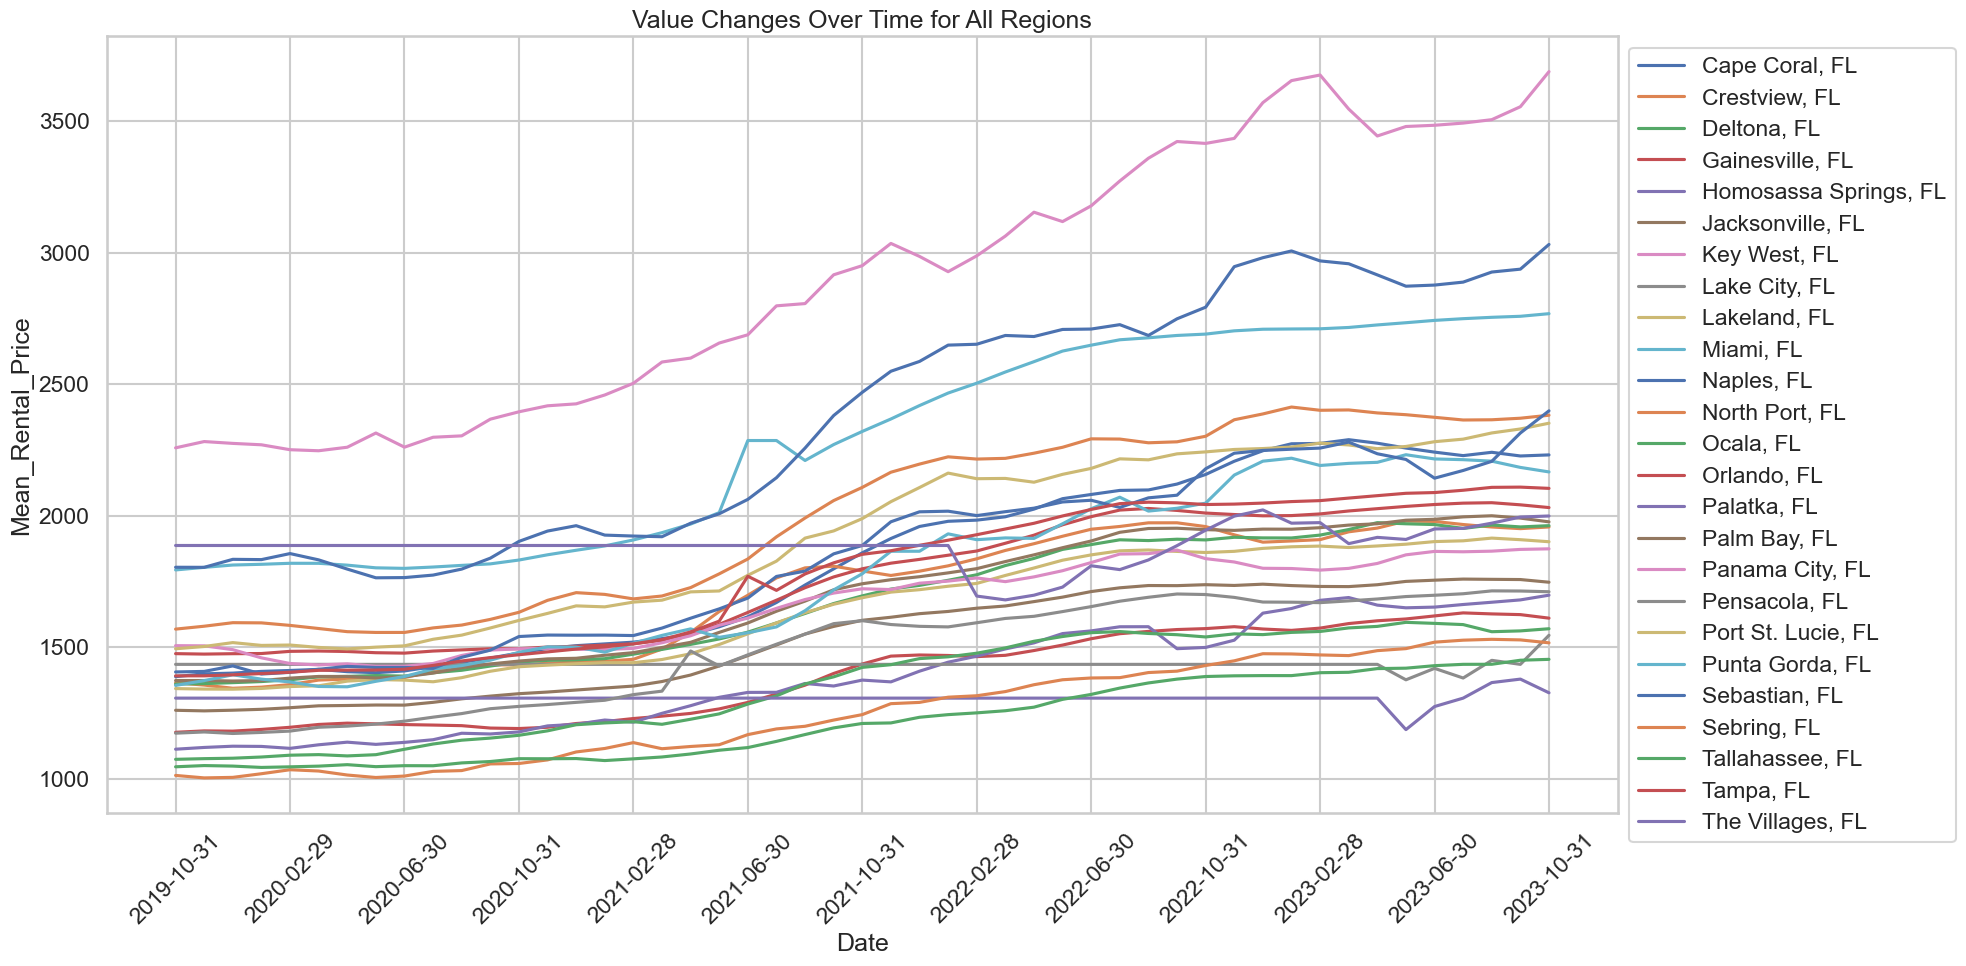

In [279]:
mean = FL_rental.groupby('RegionName')['Mean_Rental_Price'].transform('mean')
FL_rental['Mean_Rental_Price'] = FL_rental['Mean_Rental_Price'].fillna(mean)
pivot_df = FL_rental.pivot_table(index='Date', columns='RegionName', values='Mean_Rental_Price')

# Plotting using matplotlib
plt.figure(figsize=(20, 10))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Mean_Rental_Price')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)  
ax = plt.gca()  
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  
plt.tight_layout() 
plt.show()

### For Maryland

In [281]:
MD_rental=rental_df[rental_df['StateName']=='MD']

In [282]:
MD_rental = MD_rental.dropna(subset=['Mean_Rental_Price'])


In [283]:
MD_rental[['Mean_Rental_Price']]

Mean_Rental_Price
20           1488.962537
168          1004.403590
352          1301.978345
620          1488.774838
768          1010.447348
...                  ...
28968        1429.593615
29152        1679.350000
29191         862.555556
29363        2450.000000
29383        1399.000000

[159 rows x 1 columns]

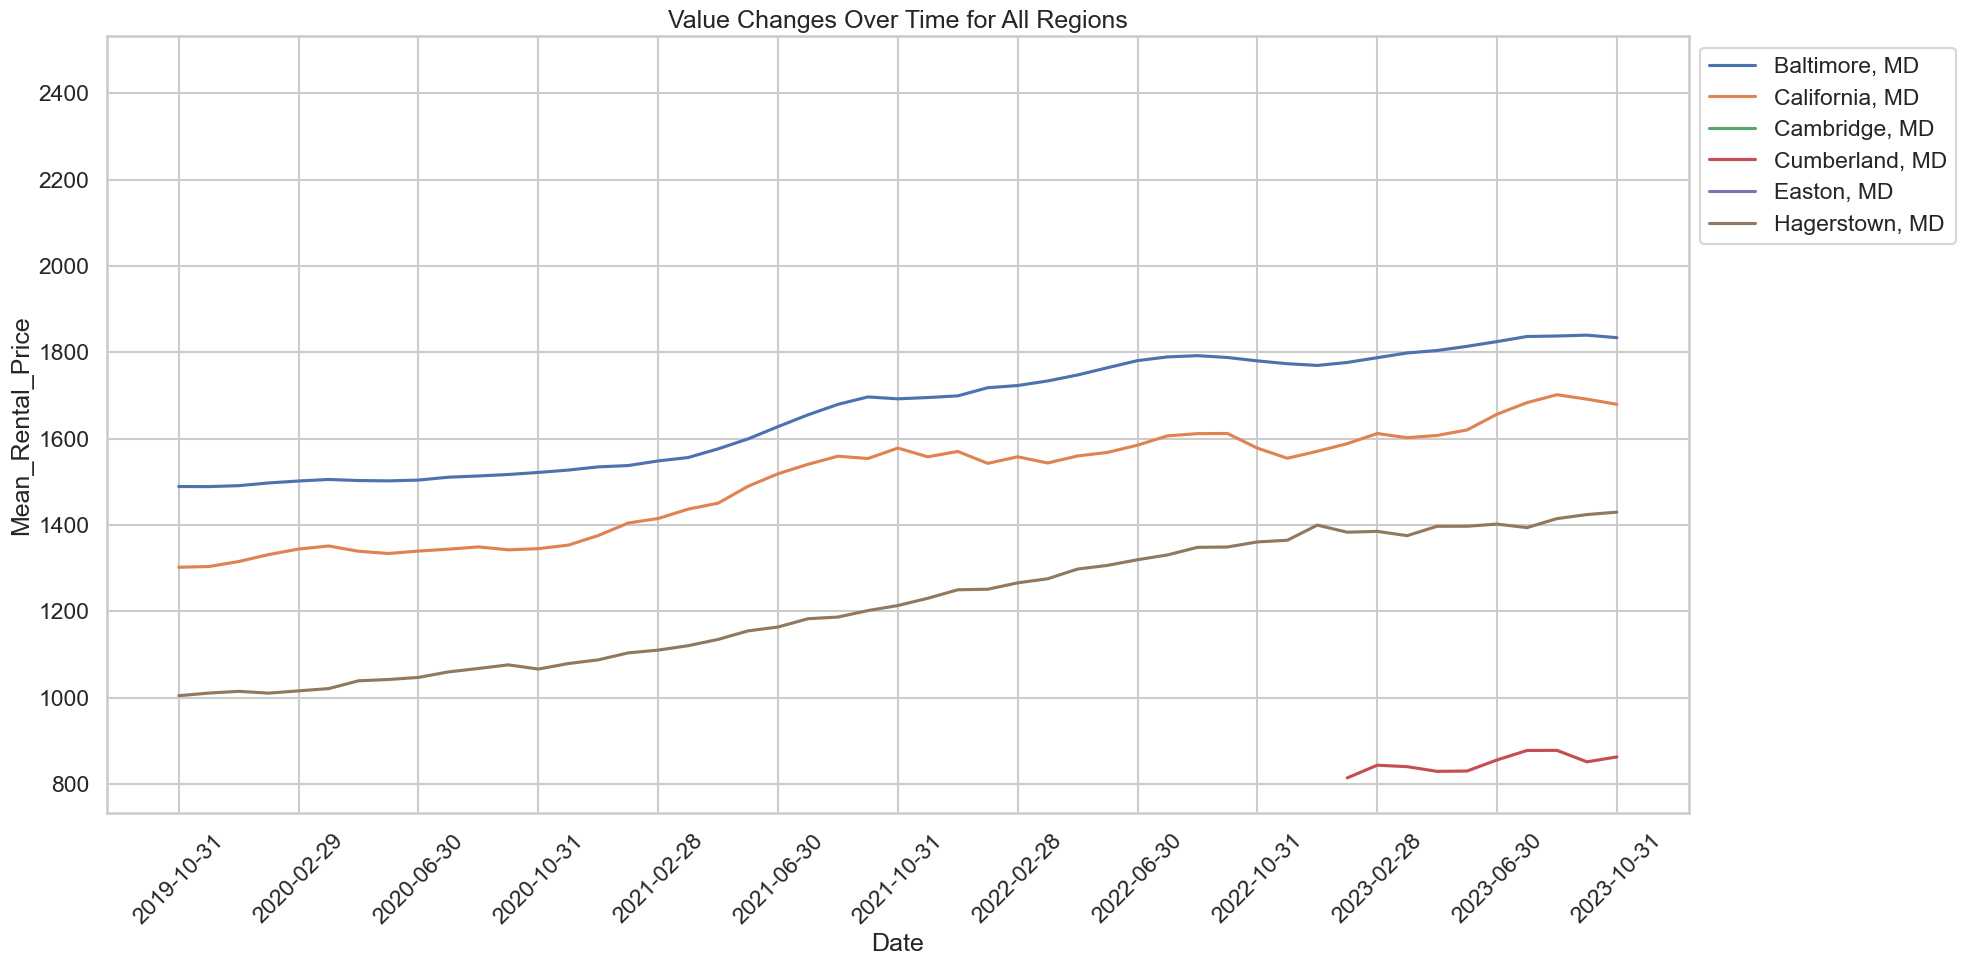

In [285]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#mean = MD_rental.groupby('RegionName')['Mean_Rental_Price'].transform('mean')
pivot_df = MD_rental.pivot_table(index='Date', columns='RegionName', values='Mean_Rental_Price')

# Plotting using matplotlib
plt.figure(figsize=(20, 10))

for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Mean_Rental_Price')
plt.legend(loc='upper left', bbox_to_anchor=(1,1)) 
plt.xticks(rotation=45)  
ax = plt.gca() 
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4)) 
plt.tight_layout()  
plt.show()

## Q6) Examining the effect on pending and closing days for a listing due to Covid

### Pending Homes - Days between listing added to the website and listing going to a pending state i.e a buyer has started the process to buy

In [286]:
df=pd.read_csv('./dataset/pending-allhomes.csv')

In [287]:
date_columns = ['2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', 
                '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', 
                '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', 
                '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
                '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', 
                '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', 
                '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
                '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31', 
                '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30', 
                '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31']


# Melt the DataFrame to go from wide to long format
pending_df = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],  # These are the columns to keep
                  value_vars=date_columns, 
                  var_name='Date',  
                  value_name='Days_count')  

In [288]:
pending_df

RegionID  SizeRank       RegionName RegionType StateName        Date  \
0        102001         0    United States    country       NaN  2019-10-31   
1        394913         1     New York, NY        msa        NY  2019-10-31   
2        753899         2  Los Angeles, CA        msa        CA  2019-10-31   
3        394463         3      Chicago, IL        msa        IL  2019-10-31   
4        394514         4       Dallas, TX        msa        TX  2019-10-31   
...         ...       ...              ...        ...       ...         ...   
35569    394784       893    Levelland, TX        msa        TX  2023-10-31   
35570    394403       899       Borger, TX        msa        TX  2023-10-31   
35571    786263       913      Ruidoso, NM        msa        NM  2023-10-31   
35572    394805       916   Los Alamos, NM        msa        NM  2023-10-31   
35573    395112       922  Spirit Lake, IA        msa        IA  2023-10-31   

       Days_count  
0            59.0  
1            92.0  
2            48.0  
3            60.0  
4            58.0  
...           ...  
35569        53.0  
35570        57.0  
35571        77.0  
35572        20.0  
35573        37.0  

[35574 rows x 7 columns]

### For Florida 

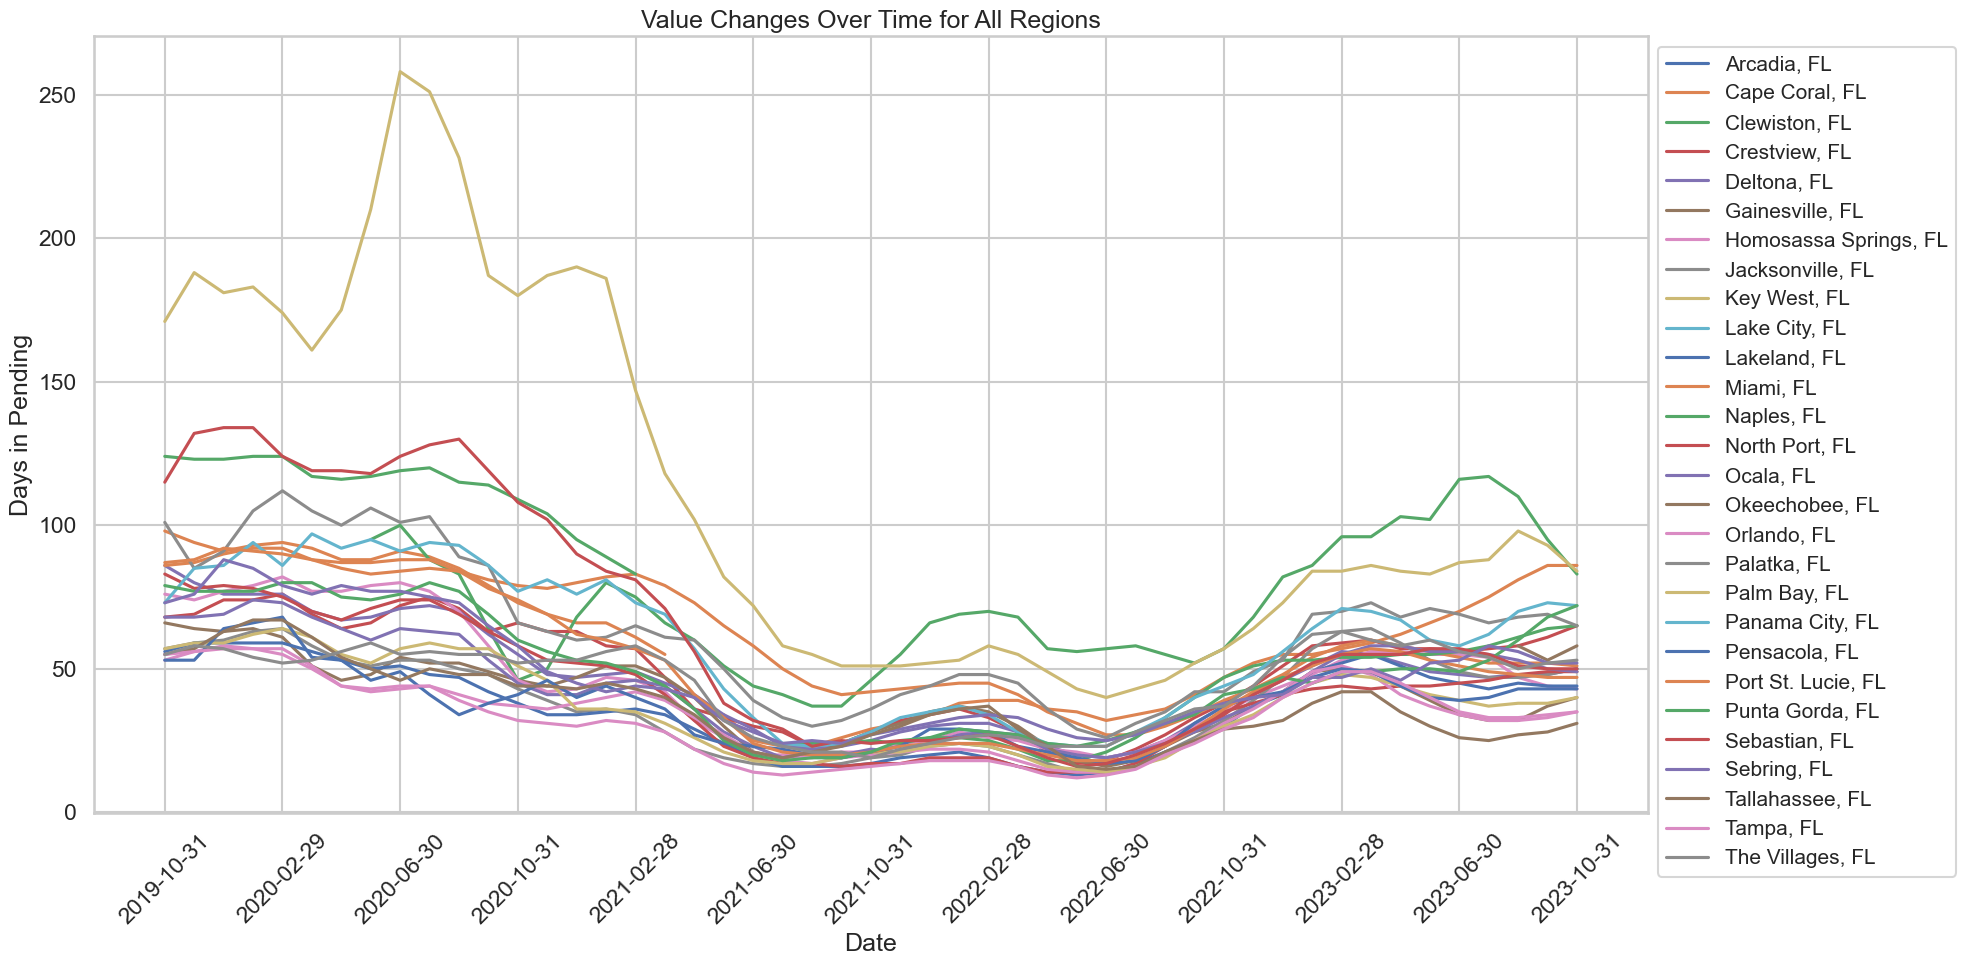

In [289]:
FL_pending=pending_df[pending_df['StateName']=='FL']
FL_pending = FL_pending.dropna(subset=['Days_count'])
mean = FL_pending.groupby('RegionName')['Days_count'].transform('mean')
FL_pending['Days_count'] = FL_pending['Days_count'].fillna(mean)
pivot_df = FL_pending.pivot_table(index='Date', columns='RegionName', values='Days_count')

# Plotting using matplotlib
plt.figure(figsize=(20, 10))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Days in Pending')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=15)  # Move the legend out of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlap
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  # Set interval of x-axis labels
plt.tight_layout()  # Adjust layout for better fit
plt.show()

### For Maryland 

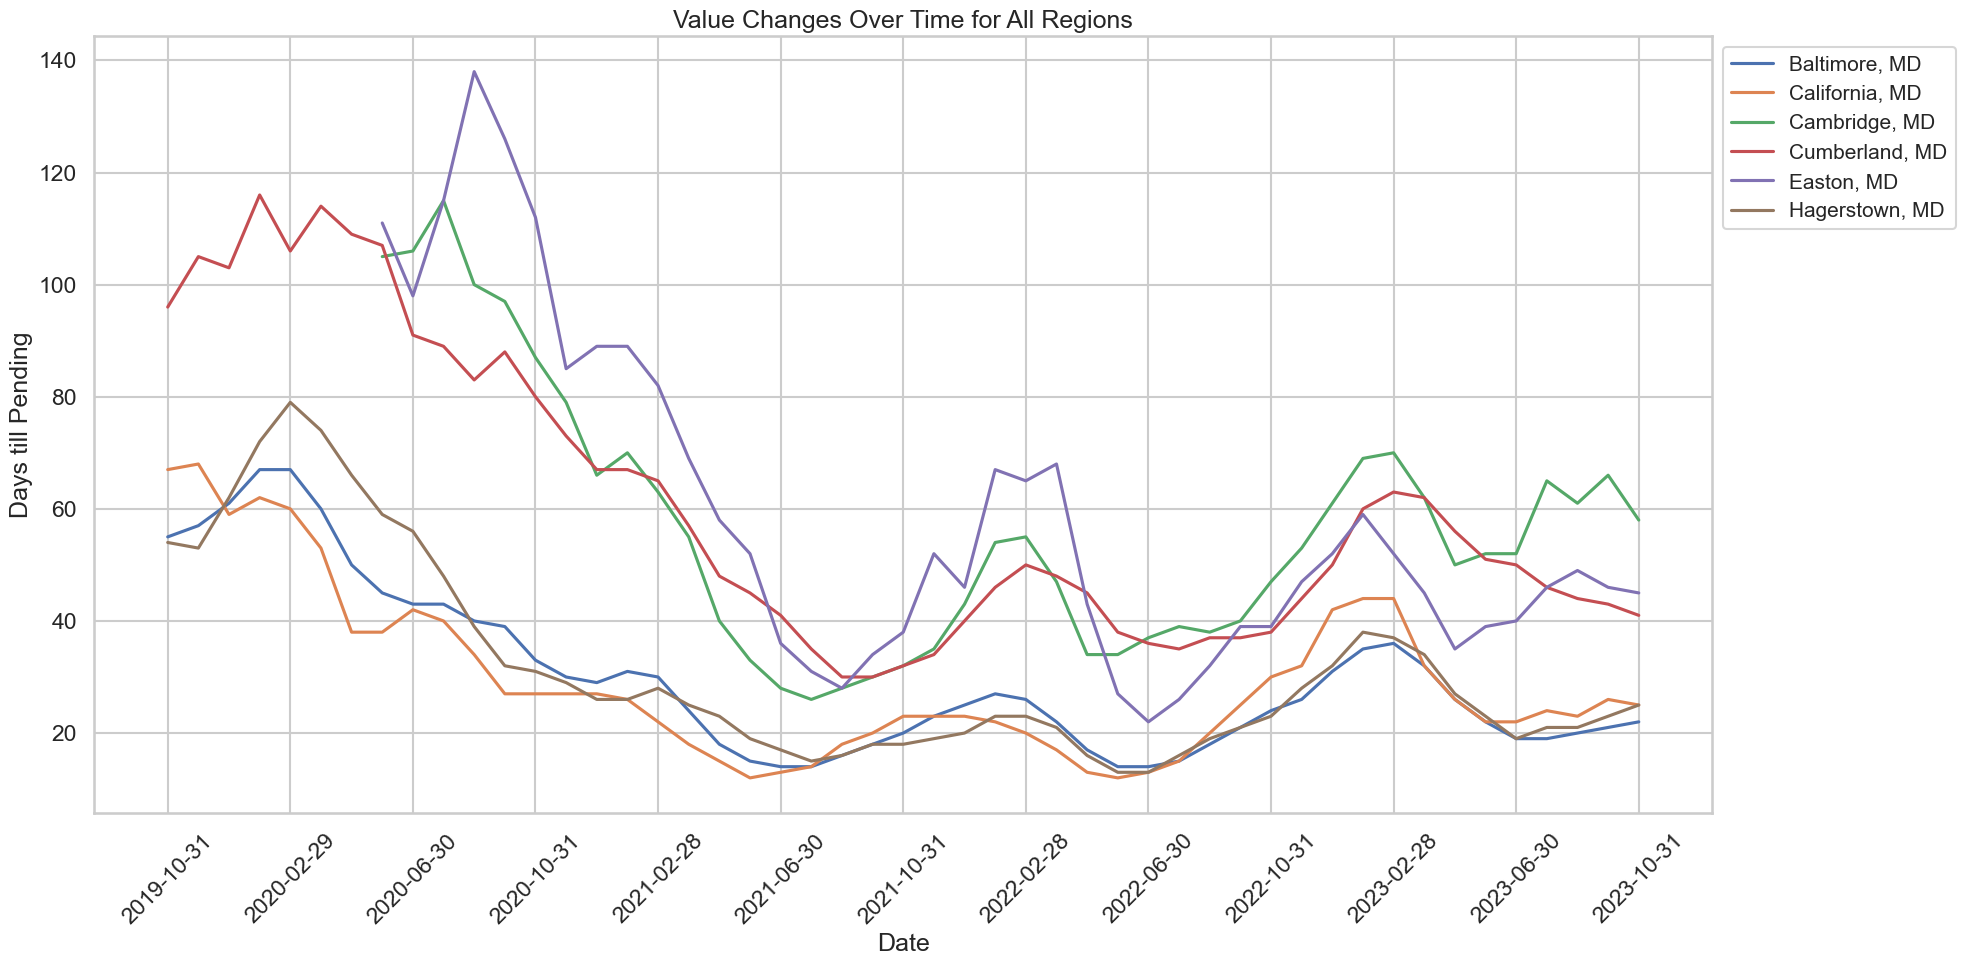

In [290]:
MD_pending=pending_df[pending_df['StateName']=='MD']
MD_pending = MD_pending.dropna(subset=['Days_count'])
mean = MD_pending.groupby('RegionName')['Days_count'].transform('mean')
MD_pending['Days_count'] = MD_pending['Days_count'].fillna(mean)
pivot_df = MD_pending.pivot_table(index='Date', columns='RegionName', values='Days_count')

# Plotting using matplotlib
plt.figure(figsize=(20, 10))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Days till Pending')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=15)  # Move the legend out of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlap
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  # Set interval of x-axis labels
plt.tight_layout()  # Adjust layout for better fit
plt.show()

## Closing - Days between listing from pending state to close state

In [171]:
df=pd.read_csv('./dataset/days_to_close.csv')

In [172]:
date_columns = ['2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', 
                '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', 
                '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', 
                '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
                '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', 
                '2021-11-30', '2021-12-31']

closing_df = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], 
                  value_vars=date_columns, 
                  var_name='Date',
                  value_name='Days_count')  

### FL

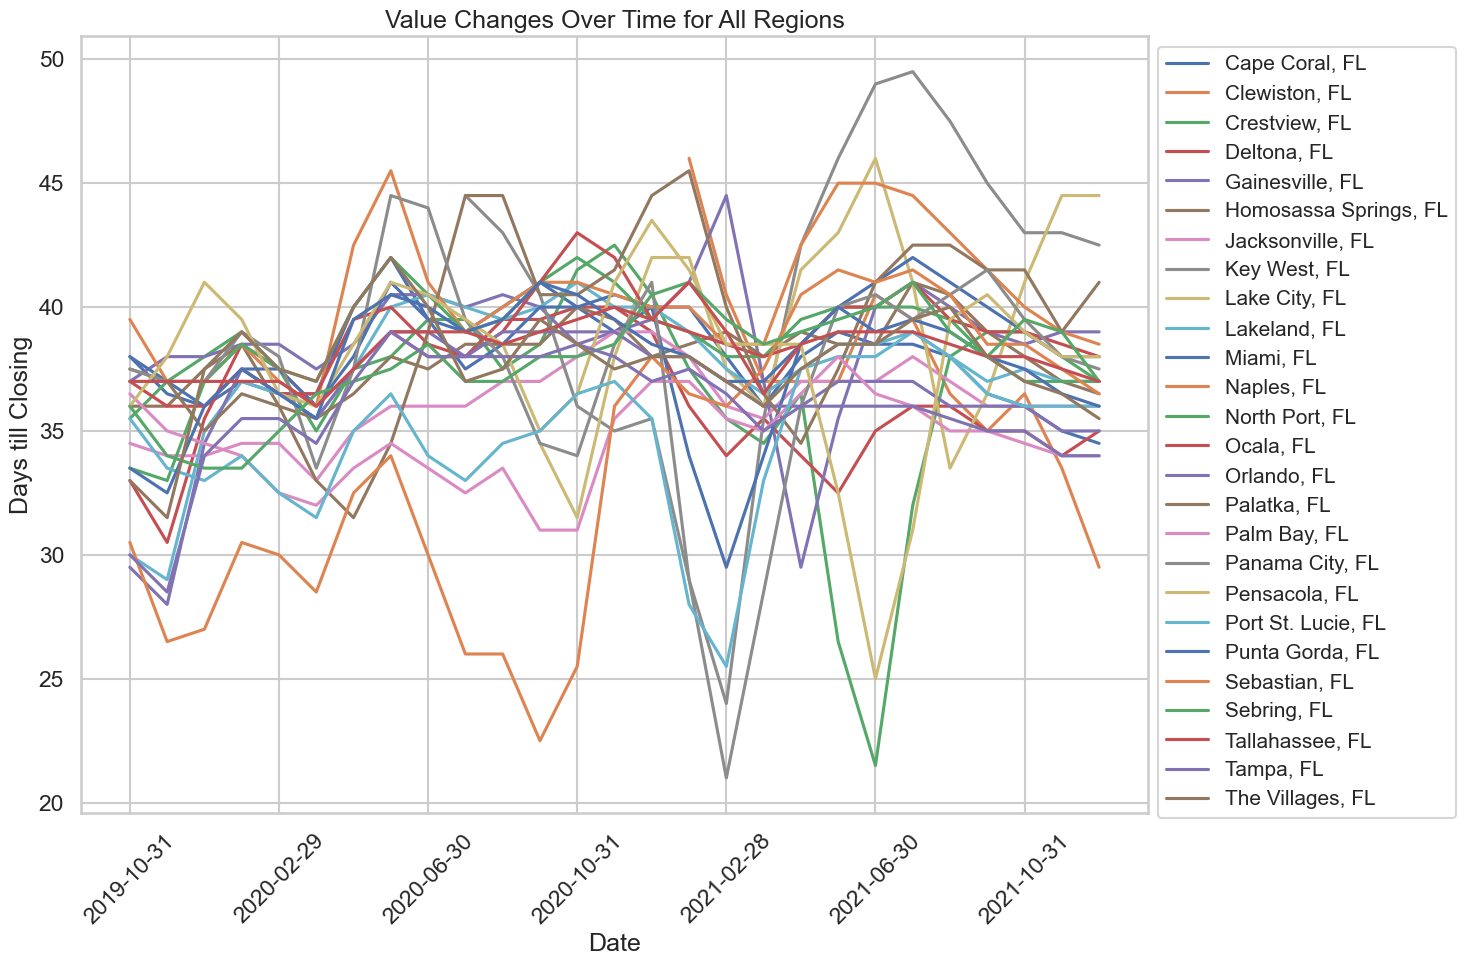

In [182]:
FL_closing=closing_df[closing_df['StateName']=='FL']
FL_closing = FL_closing.dropna(subset=['Days_count'])
pivot_df = FL_closing.pivot_table(index='Date', columns='RegionName', values='Days_count')

# Plotting using matplotlib
plt.figure(figsize=(15, 10))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Days till Closing')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=15)  # Move the legend out of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlap
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  # Set interval of x-axis labels
plt.tight_layout()  # Adjust layout for better fit
plt.show()

### MD

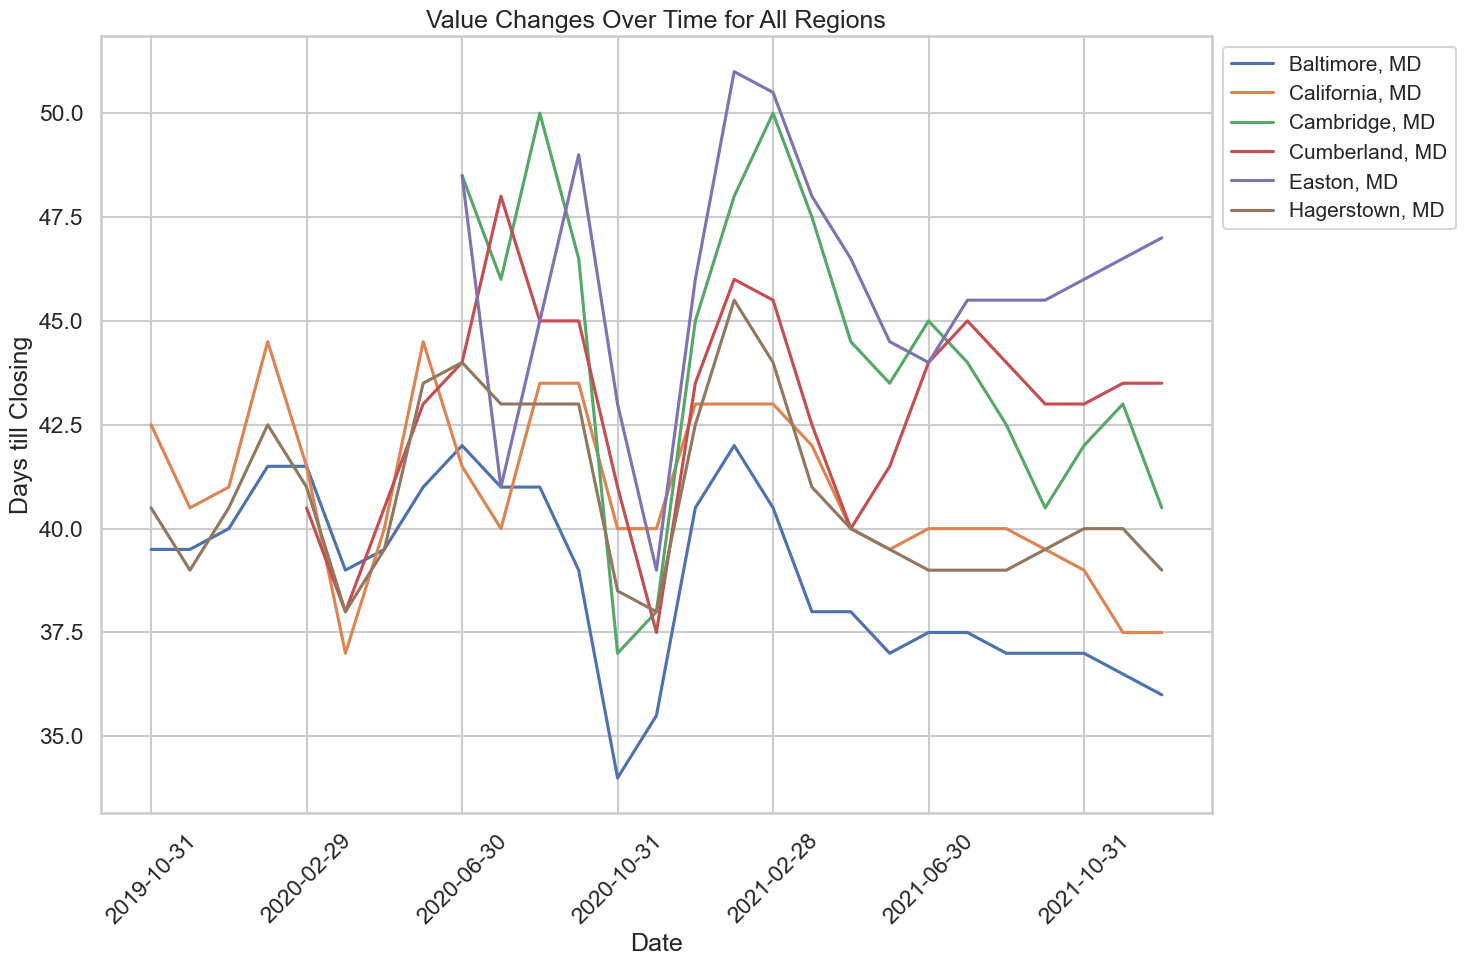

In [181]:
MD_closing=closing_df[closing_df['StateName']=='MD']
MD_closing = MD_closing.dropna(subset=['Days_count'])
pivot_df = MD_closing.pivot_table(index='Date', columns='RegionName', values='Days_count')

# Plotting using matplotlib
plt.figure(figsize=(15, 10))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Days till Closing')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=15)  # Move the legend out of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlap
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  # Set interval of x-axis labels
plt.tight_layout()  # Adjust layout for better fit
plt.show()

### Comparing Home prices for FL,MD and the US 

In [183]:
df=pd.read_csv('./dataset/AllHomes-State.csv')
date_columns = ['2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', 
                '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', 
                '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', 
                '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
                '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', 
                '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', 
                '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
                '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31', 
                '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30', 
                '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31']


# Melt the DataFrame to go from wide to long format
us_df = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],  # These are the columns to keep
                  value_vars=date_columns,  # These are the columns to melt
                  var_name='Date',  # The name of the new column that will contain the dates
                  value_name='Mean_Home_Price')  # The name of the new column that will contain the values

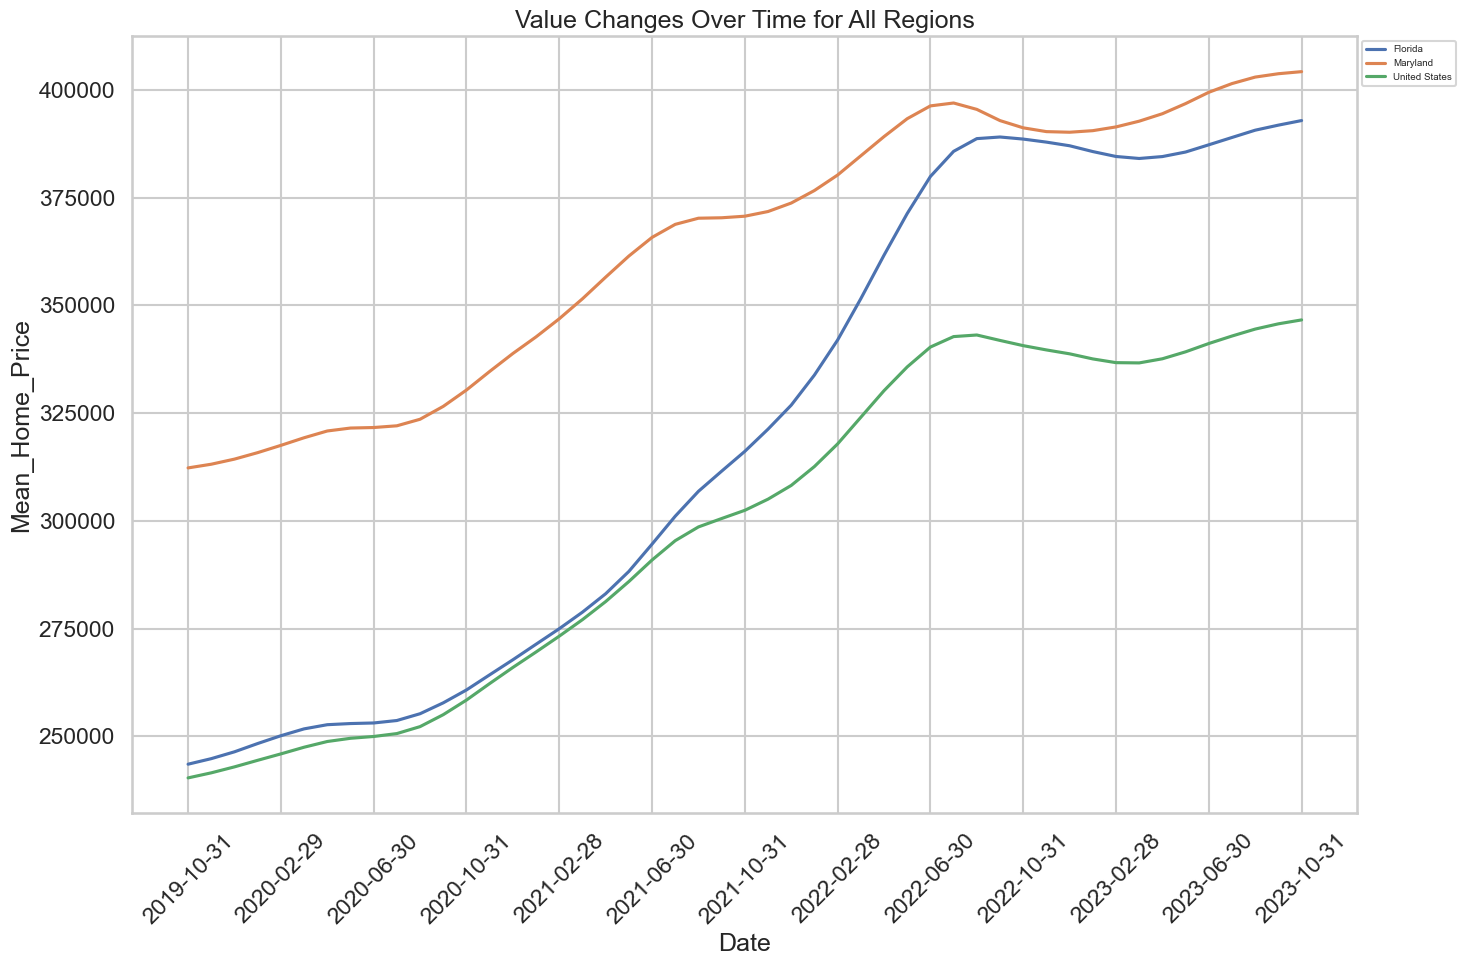

In [190]:
mean = us_df.groupby('RegionName')['Mean_Home_Price'].transform('mean')
us_df['Mean_Home_Price'] = us_df['Mean_Home_Price'].fillna(mean)
regions_of_interest = ['United States','Florida','Maryland']

filtered_df = us_df[us_df['RegionName'].isin(regions_of_interest)]
pivot_df = filtered_df.pivot_table(index='Date', columns='RegionName', values='Mean_Home_Price')

# Plotting using matplotlib
plt.figure(figsize=(15, 10))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Mean_Home_Price')
plt.legend(loc='upper left', bbox_to_anchor=(1,1),fontsize=7)  # Move the legend out of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlap
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  # Set interval of x-axis labels

plt.tight_layout()  # Adjust layout for better fit
plt.show()


### Comparing all US states 

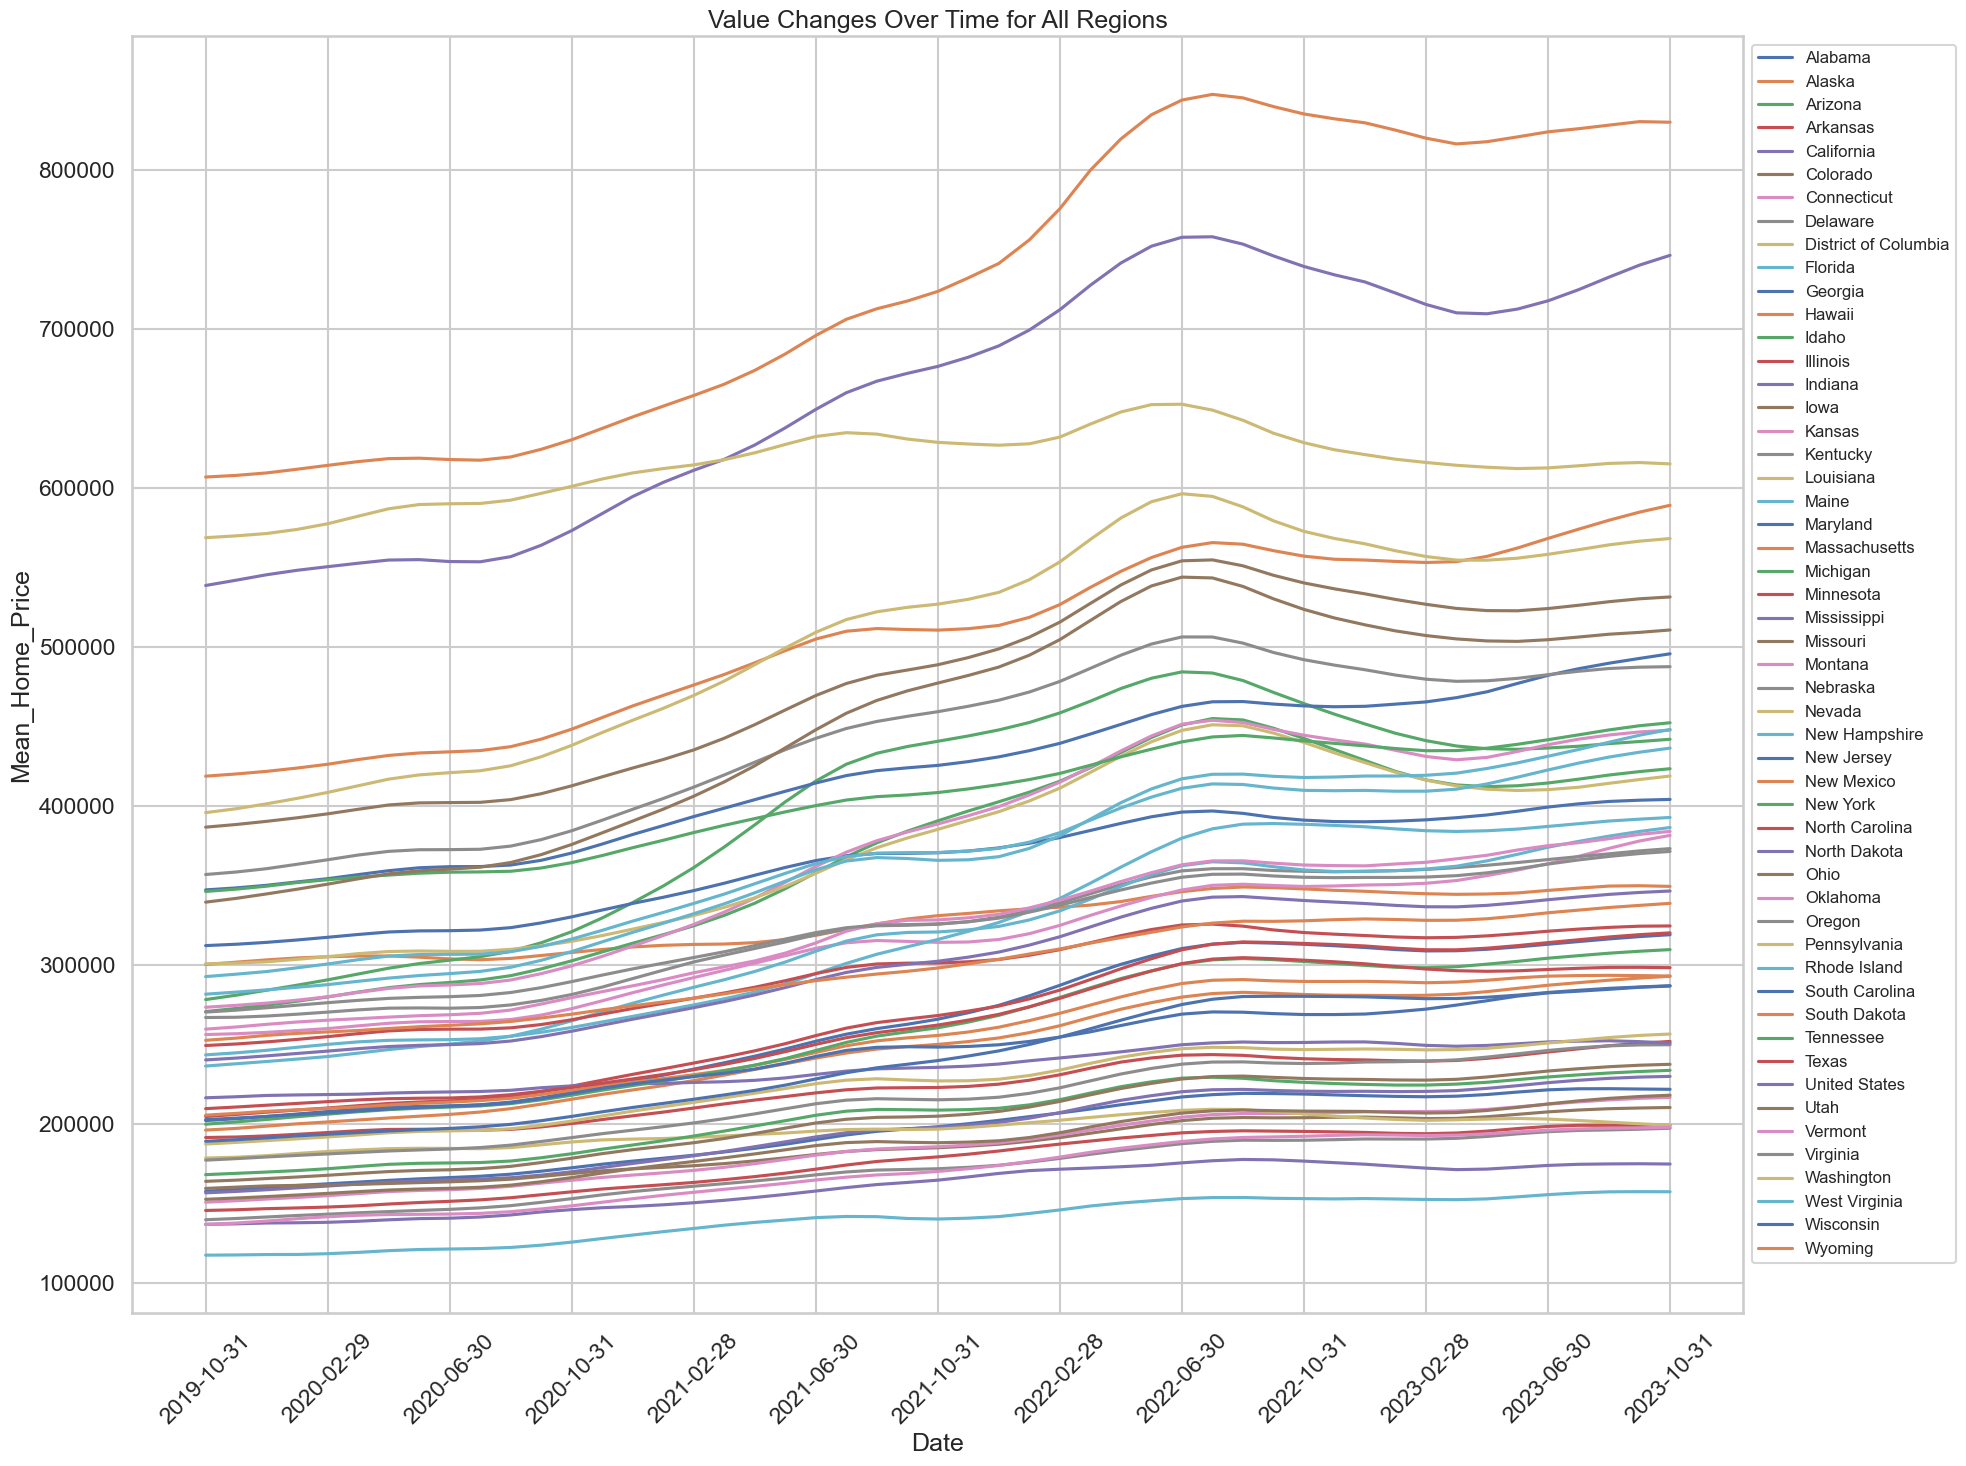

In [196]:
mean = us_df.groupby('RegionName')['Mean_Home_Price'].transform('mean')
us_df['Mean_Home_Price'] = us_df['Mean_Home_Price'].fillna(mean)

pivot_df = us_df.pivot_table(index='Date', columns='RegionName', values='Mean_Home_Price')

# Plotting using matplotlib
plt.figure(figsize=(20, 15))

# Plot for all regions, iterate through the columns of pivot_df
for region in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[region], label=region)

plt.title('Value Changes Over Time for All Regions')
plt.xlabel('Date')
plt.ylabel('Mean_Home_Price')
plt.legend(loc='upper left', bbox_to_anchor=(1,1),fontsize=12)  # Move the legend out of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to avoid overlap
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))  # Set interval of x-axis labels

plt.tight_layout()  # Adjust layout for better fit
plt.show()
